In [3]:
import json
import numpy as np
import pandas as pd
from pathlib import Path
import os
import sys
import warnings
from utils import *
import matplotlib.pyplot as plt
import seaborn as sns

warnings.simplefilter('ignore')

sys.path.append('../../utilities')
sys.path.append('../../models/grt123')
sys.path.append('../../models/grt123/training')
sys.path.append('../../models/grt123/preprocessing/')

# from layers import nms,iou
from summit_utils import SummitScan, xyz2irc
from evaluation import noduleCADEvaluation

workspace_path = Path(os.getcwd()).parent.parent


# Test Balanced Data

## GRT123

/Users/john/Projects/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_metadata.csv
Total number of included nodule annotations: 699
Total number of nodule annotations: 699
Cases: 595
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: 380


100%|██████████| 1000/1000 [00:19<00:00, 52.35it/s]


0                   159                 476   \
0  0.15 (0.12 - 0.19)  0.21 (0.17 - 0.25)  0.29 (0.25 - 0.34)   

                 1111                2381                4920  \
0  0.42 (0.37 - 0.47)  0.56 (0.51 - 0.61)  0.72 (0.68 - 0.76)   

                 9999  
0  0.82 (0.79 - 0.85)

fps  mean_sens  low_sens  high_sens
0     0.12       0.15      0.12       0.19
159   0.25       0.21      0.17       0.25
476   0.50       0.29      0.25       0.34
1111  1.00       0.42      0.37       0.47
2381  2.00       0.56      0.51       0.61
4920  4.00       0.72      0.68       0.76
9999  8.00       0.82      0.79       0.85

Mean Sensitivity: 0.45 Low Sensitivity: 0.41 High Sensitivity: 0.5


True positives        622
0                                    False positives  12548.000
1                                    False negatives     77.000
2                                     True negatives      0.000
3                         Total number of candidates  13189.000
4                            Total number of nodules    699.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...     20.000
7                                        Sensitivity      0.890
8              Average number of candidates per scan     22.166

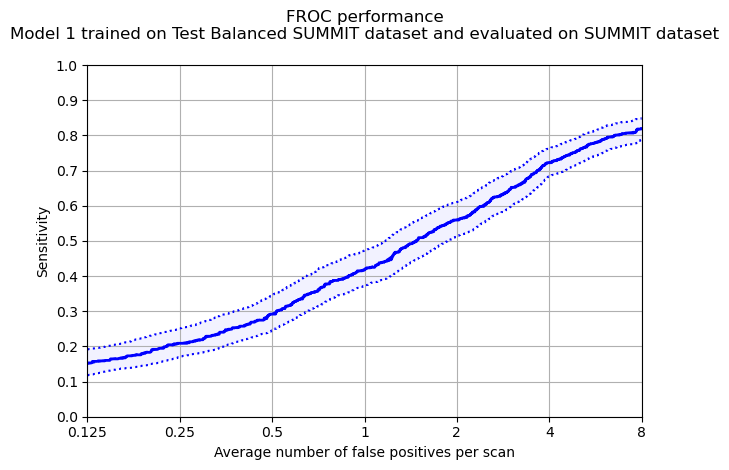

In [4]:
# Add in diameter cuts for later analysis
annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_metadata.csv')
annotations['diameter_cats'] = pd.cut(
    annotations['diameter_mm'],
    bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 999],
    labels=['1. 0-5', '2. 5-10', '3. 10-15', '4. 15-20', '5. 20-25', '6. 25-30', '7. 30-35', '8. 35-40', '9. 40+']
)

# save back to the metadata file
annotations.to_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_metadata.csv', index=False)
grt123_summit_summit = noduleCADEvaluation(
    annotations_filename=f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_metadata.csv',
    annotations_excluded_filename=f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv',
    seriesuids_filename=f'{workspace_path}/metadata/summit/test_balanced/test_scans.csv',
    results_filename=f"{workspace_path}/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_predictions.csv",    
    filter='\nModel 1 trained on Test Balanced SUMMIT dataset and evaluated on SUMMIT dataset\n',
    outputDir=f'{workspace_path}/results/grt123/trained_summit/summit/test_balanced',
)
caluclate_cpm_from_bootstrapping(f'{workspace_path}/results/grt123/trained_summit/summit/test_balanced/froc_test_balanced_predictions_bootstrapping.csv')
show_metrics(f'{workspace_path}/results/grt123/trained_summit/summit/test_balanced/CADAnalysis.txt')

### Gender analysis

In [5]:
def set_is_actionable(row):
    if row['radiology_report_management_plan_final'] in ['3_MONTH_FOLLOW_UP_SCAN','URGENT_REFERRAL', 'ALWAYS_SCAN_AT_YEAR_1']:
        return 'Actonable'
    else:
        return 'Non-Actionable'

scan_metadata = (
    pd.read_csv(f'{workspace_path}/metadata/summit/test_balanced/test_scans_metadata.csv')
    .assign(name=lambda df: df['LDCT_RADIOLOGY_REPORT_main_participant_id'] + '_Y0_BASELINE_A')
    .assign(is_actionable=lambda df: df.apply(set_is_actionable, axis=1))
    .assign(gender_is_actionable=lambda df: df.apply(set_gender_is_actionable, axis=1))    
    .assign(gender_is_not_actionable=lambda df: df.apply(set_gender_is_not_actionable, axis=1))    
    .assign(ethnic_group_is_actionable=lambda df: df.apply(set_ethnic_group_is_actionable, axis=1))    
    .assign(ethnic_group_is_not_actionable=lambda df: df.apply(set_ethnic_group_is_not_actionable, axis=1))    
    .rename(columns={
        'participant_details_gender':'gender',
        'lung_health_check_demographics_race_ethnicgroup':'ethnic_group'
    })
)

annotations_excluded = pd.read_csv(f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv')

annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_metadata.csv')

predictions = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_predictions.csv')

protected_group = 'gender'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/test_balanced/{protected_group}'
)

NameError: name 'set_gender_by_actionable' is not defined

### Ethnicity analysis

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpiky36t92/annotations.csv
Total number of included nodule annotations: 250
Total number of nodule annotations: 250
Cases: 199


100%|██████████| 1000/1000 [00:05<00:00, 193.90it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.12      0.07       0.18
159   0.25       0.17      0.12       0.24
476   0.50       0.26      0.19       0.34
1111  1.00       0.38      0.30       0.48
2381  2.00       0.50      0.41       0.60
4920  4.00       0.69      0.61       0.77
9999  8.00       0.82      0.76       0.88

Mean Sensitivity: 0.42 Low Sensitivity: 0.35 High Sensitivity: 0.5


True positives       224
0                                    False positives  4395.000
1                                    False negatives    26.000
2                                     True negatives     0.000
3                         Total number of candidates  4626.000
4                            Total number of nodules   250.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     7.000
7                                        Sensitivity     0.896
8              Average number of candidates per scan    23.246

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpyz59sqad/annotations.csv
Total number of included nodule annotations: 207
Total number of nodule annotations: 207
Cases: 199


100%|██████████| 1000/1000 [00:04<00:00, 220.83it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.11      0.05       0.17
159   0.25       0.19      0.11       0.26
476   0.50       0.25      0.17       0.33
1111  1.00       0.38      0.30       0.47
2381  2.00       0.54      0.47       0.62
4920  4.00       0.70      0.63       0.76
9999  8.00       0.78      0.72       0.84

Mean Sensitivity: 0.42 Low Sensitivity: 0.35 High Sensitivity: 0.49


True positives       179
0                                    False positives  3916.000
1                                    False negatives    28.000
2                                     True negatives     0.000
3                         Total number of candidates  4099.000
4                            Total number of nodules   207.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     4.000
7                                        Sensitivity     0.865
8              Average number of candidates per scan    20.598

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp3eajfotp/annotations.csv
Total number of included nodule annotations: 242
Total number of nodule annotations: 242
Cases: 199
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: 380


100%|██████████| 1000/1000 [00:04<00:00, 202.08it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.22      0.16       0.28
159   0.25       0.26      0.20       0.33
476   0.50       0.37      0.30       0.44
1111  1.00       0.50      0.42       0.57
2381  2.00       0.65      0.58       0.71
4920  4.00       0.77      0.71       0.83
9999  8.00       0.84      0.80       0.89

Mean Sensitivity: 0.52 Low Sensitivity: 0.45 High Sensitivity: 0.58


True positives       219
0                                    False positives  4237.000
1                                    False negatives    23.000
2                                     True negatives     0.000
3                         Total number of candidates  4464.000
4                            Total number of nodules   242.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     9.000
7                                        Sensitivity     0.905
8              Average number of candidates per scan    22.432

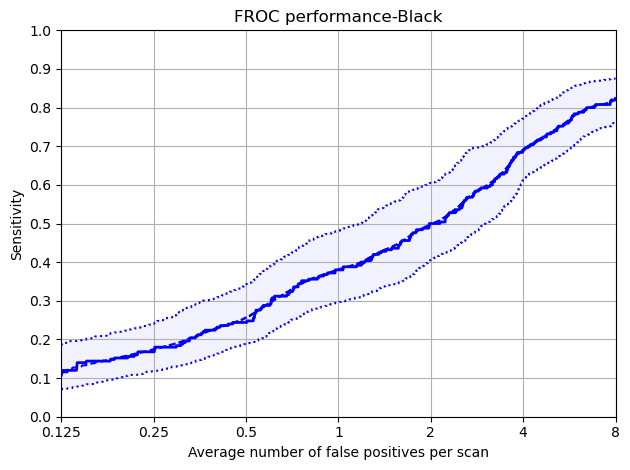

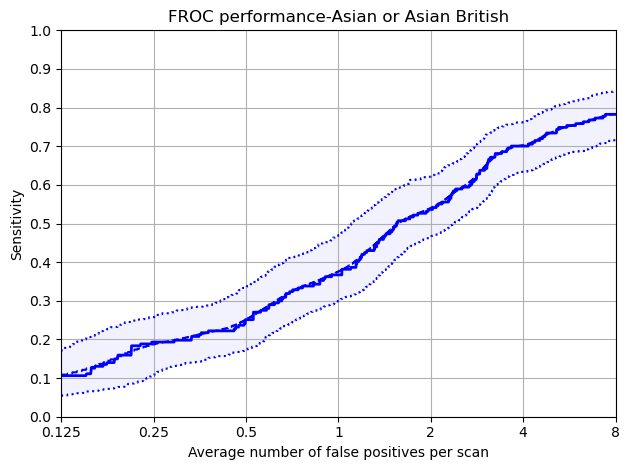

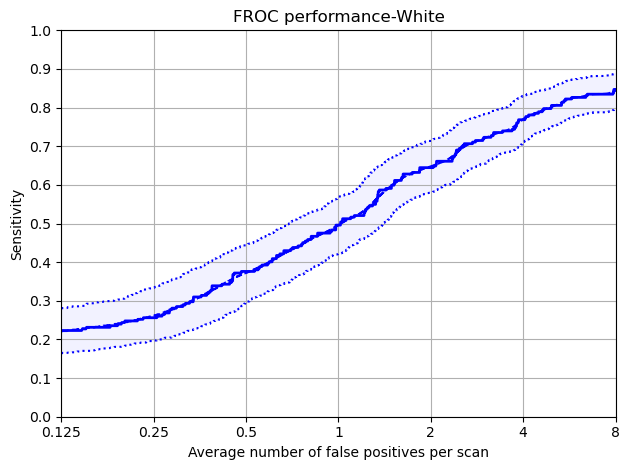

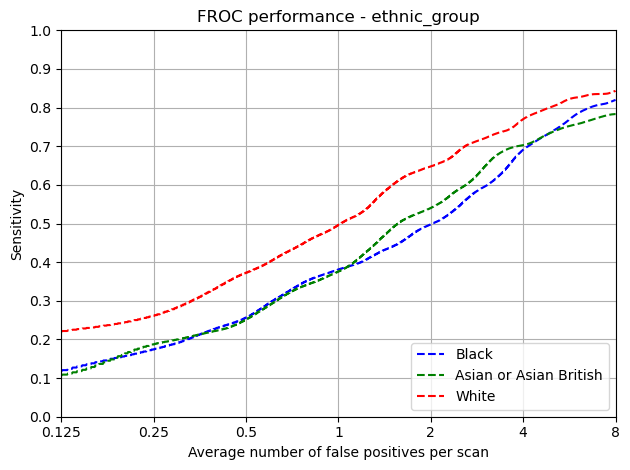

In [ ]:
protected_group = 'ethnic_group'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/test_balanced/{protected_group}'
)

### Is Actionable

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpxdkgmv82/annotations.csv
Total number of included nodule annotations: 258
Total number of nodule annotations: 258
Cases: 424
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: 380


100%|██████████| 1000/1000 [00:10<00:00, 92.67it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.16      0.11       0.21
159   0.25       0.22      0.17       0.28
476   0.50       0.32      0.25       0.38
1111  1.00       0.49      0.43       0.56
2381  2.00       0.67      0.61       0.74
4920  4.00       0.80      0.74       0.86
9999  8.00       0.89      0.84       0.93

Mean Sensitivity: 0.51 Low Sensitivity: 0.45 High Sensitivity: 0.57


True positives       242
0                                    False positives  8664.000
1                                    False negatives    16.000
2                                     True negatives     0.000
3                         Total number of candidates  8905.000
4                            Total number of nodules   258.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     0.000
7                                        Sensitivity     0.938
8              Average number of candidates per scan    21.002

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpn4b30_ih/annotations.csv
Total number of included nodule annotations: 441
Total number of nodule annotations: 441
Cases: 172


100%|██████████| 1000/1000 [00:04<00:00, 210.59it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.14      0.10       0.19
159   0.25       0.19      0.14       0.25
476   0.50       0.27      0.21       0.34
1111  1.00       0.37      0.31       0.44
2381  2.00       0.49      0.43       0.57
4920  4.00       0.66      0.59       0.72
9999  8.00       0.77      0.72       0.81

Mean Sensitivity: 0.41 Low Sensitivity: 0.36 High Sensitivity: 0.47


True positives       380
0                                    False positives  3884.000
1                                    False negatives    61.000
2                                     True negatives     0.000
3                         Total number of candidates  4284.000
4                            Total number of nodules   441.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    20.000
7                                        Sensitivity     0.862
8              Average number of candidates per scan    24.907

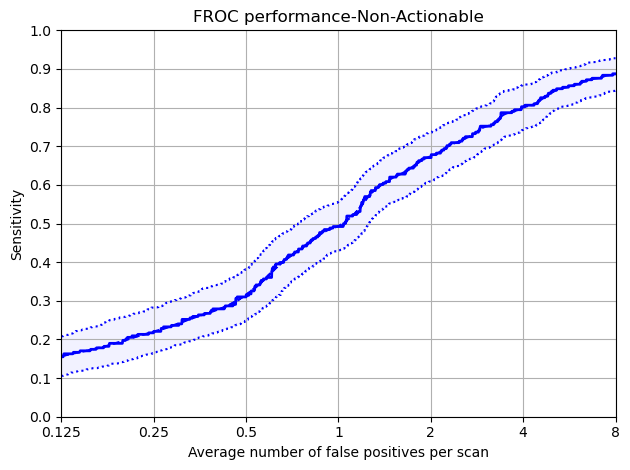

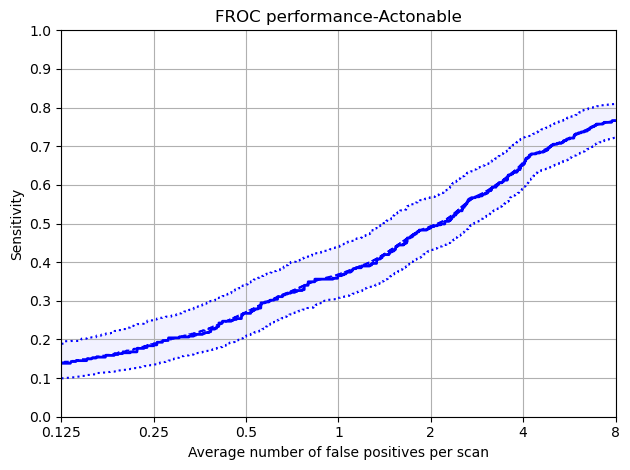

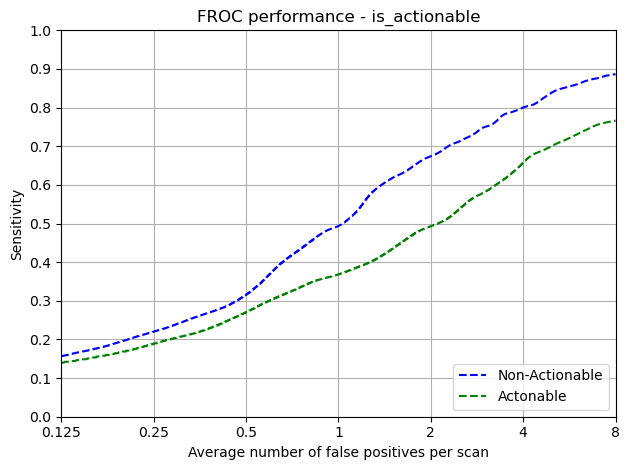

In [ ]:
protected_group = 'is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/test_balanced/{protected_group}'
)

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmph0mwarrm/annotations.csv
Total number of included nodule annotations: 137
Total number of nodule annotations: 137
Cases: 254


100%|██████████| 1000/1000 [00:06<00:00, 159.81it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.15      0.07       0.24
159   0.25       0.23      0.15       0.31
476   0.50       0.32      0.24       0.40
1111  1.00       0.55      0.47       0.64
2381  2.00       0.71      0.63       0.79
4920  4.00       0.83      0.76       0.89
9999  8.00       0.90      0.85       0.95

Mean Sensitivity: 0.53 Low Sensitivity: 0.45 High Sensitivity: 0.6


True positives       130
0                                    False positives  5580.000
1                                    False negatives     7.000
2                                     True negatives     0.000
3                         Total number of candidates  5710.000
4                            Total number of nodules   137.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     0.000
7                                        Sensitivity     0.949
8              Average number of candidates per scan    22.480

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpk65jwu7q/annotations.csv
Total number of included nodule annotations: 121
Total number of nodule annotations: 121
Cases: 171
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: 380


100%|██████████| 1000/1000 [00:03<00:00, 283.87it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.16      0.09       0.24
159   0.25       0.22      0.14       0.31
476   0.50       0.33      0.24       0.42
1111  1.00       0.46      0.35       0.57
2381  2.00       0.64      0.53       0.73
4920  4.00       0.77      0.67       0.86
9999  8.00       0.87      0.80       0.94

Mean Sensitivity: 0.49 Low Sensitivity: 0.4 High Sensitivity: 0.58


True positives       112
0                                    False positives  3084.000
1                                    False negatives     9.000
2                                     True negatives     0.000
3                         Total number of candidates  3195.000
4                            Total number of nodules   121.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     0.000
7                                        Sensitivity     0.926
8              Average number of candidates per scan    18.684

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmphe52cy2k/annotations.csv
Total number of included nodule annotations: 263
Total number of nodule annotations: 263
Cases: 92


100%|██████████| 1000/1000 [00:03<00:00, 332.50it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.12      0.07       0.19
159   0.25       0.17      0.10       0.25
476   0.50       0.23      0.15       0.32
1111  1.00       0.32      0.24       0.41
2381  2.00       0.43      0.33       0.53
4920  4.00       0.61      0.50       0.70
9999  8.00       0.77      0.70       0.83

Mean Sensitivity: 0.38 Low Sensitivity: 0.3 High Sensitivity: 0.46


True positives       230
0                                    False positives  2342.000
1                                    False negatives    33.000
2                                     True negatives     0.000
3                         Total number of candidates  2584.000
4                            Total number of nodules   263.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    12.000
7                                        Sensitivity     0.875
8              Average number of candidates per scan    28.087

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpythnj2jf/annotations.csv
Total number of included nodule annotations: 178
Total number of nodule annotations: 178
Cases: 81


100%|██████████| 1000/1000 [00:02<00:00, 455.31it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.17      0.11       0.25
159   0.25       0.22      0.15       0.31
476   0.50       0.33      0.24       0.43
1111  1.00       0.45      0.36       0.55
2381  2.00       0.58      0.48       0.70
4920  4.00       0.70      0.63       0.78
9999  8.00       0.77      0.70       0.84

Mean Sensitivity: 0.46 Low Sensitivity: 0.38 High Sensitivity: 0.55


True positives       150
0                                    False positives  1542.000
1                                    False negatives    28.000
2                                     True negatives     0.000
3                         Total number of candidates  1700.000
4                            Total number of nodules   178.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     8.000
7                                        Sensitivity     0.843
8              Average number of candidates per scan    20.988

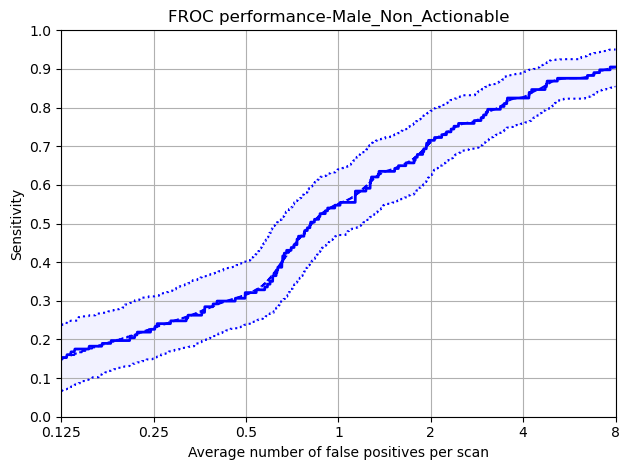

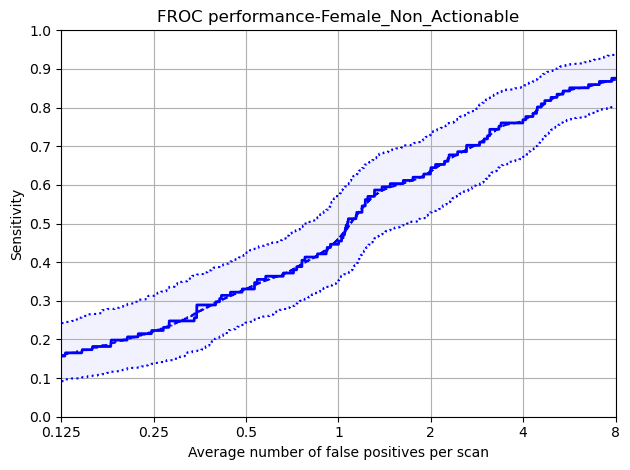

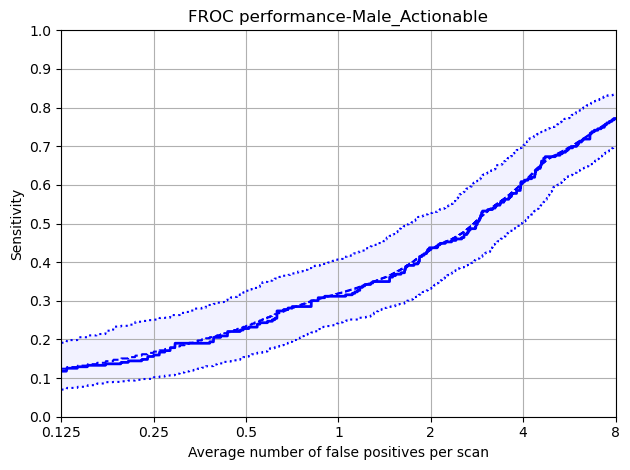

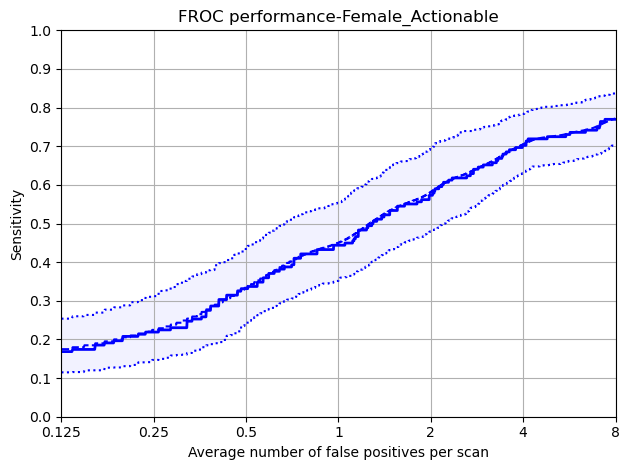

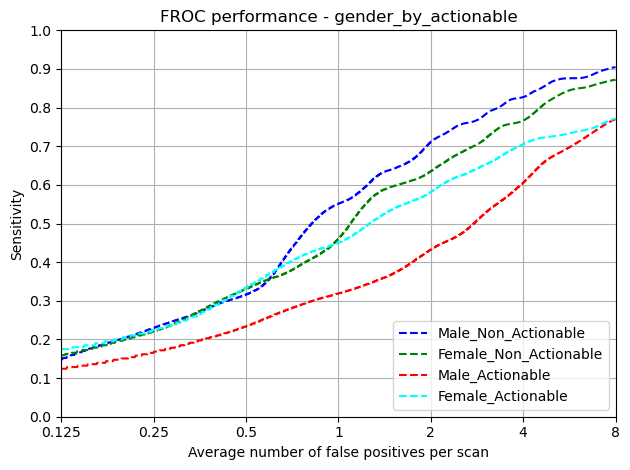

In [ ]:
protected_group = 'gender_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/test_balanced/{protected_group}'
)

In [ ]:
protected_group = 'gender_is_not_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/test_balanced/{protected_group}'
)

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpyvutr198/annotations.csv
Total number of included nodule annotations: 89
Total number of nodule annotations: 89
Cases: 148


100%|██████████| 1000/1000 [00:03<00:00, 278.29it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.15      0.03       0.28
159   0.25       0.23      0.13       0.35
476   0.50       0.32      0.20       0.45
1111  1.00       0.54      0.42       0.66
2381  2.00       0.68      0.58       0.78
4920  4.00       0.79      0.69       0.88
9999  8.00       0.89      0.83       0.95

Mean Sensitivity: 0.51 Low Sensitivity: 0.41 High Sensitivity: 0.62


True positives        81
0                                    False positives  3251.000
1                                    False negatives     8.000
2                                     True negatives     0.000
3                         Total number of candidates  3332.000
4                            Total number of nodules    89.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     0.000
7                                        Sensitivity     0.910
8              Average number of candidates per scan    22.514

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpzkrnhz_e/annotations.csv
Total number of included nodule annotations: 77
Total number of nodule annotations: 77
Cases: 141


100%|██████████| 1000/1000 [00:02<00:00, 346.87it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.15      0.05       0.27
159   0.25       0.21      0.13       0.29
476   0.50       0.29      0.19       0.41
1111  1.00       0.48      0.35       0.62
2381  2.00       0.69      0.58       0.79
4920  4.00       0.80      0.69       0.90
9999  8.00       0.88      0.79       0.95

Mean Sensitivity: 0.5 Low Sensitivity: 0.4 High Sensitivity: 0.6


True positives        75
0                                    False positives  2517.000
1                                    False negatives     2.000
2                                     True negatives     0.000
3                         Total number of candidates  2592.000
4                            Total number of nodules    77.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     0.000
7                                        Sensitivity     0.974
8              Average number of candidates per scan    18.383

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpbkq6zlyn/annotations.csv
Total number of included nodule annotations: 92
Total number of nodule annotations: 92
Cases: 137
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: 380


100%|██████████| 1000/1000 [00:03<00:00, 311.24it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.19      0.11       0.27
159   0.25       0.22      0.14       0.31
476   0.50       0.36      0.24       0.46
1111  1.00       0.49      0.39       0.58
2381  2.00       0.68      0.58       0.77
4920  4.00       0.81      0.71       0.89
9999  8.00       0.89      0.82       0.95

Mean Sensitivity: 0.52 Low Sensitivity: 0.43 High Sensitivity: 0.6


True positives        86
0                                    False positives  2896.000
1                                    False negatives     6.000
2                                     True negatives     0.000
3                         Total number of candidates  2981.000
4                            Total number of nodules    92.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     0.000
7                                        Sensitivity     0.935
8              Average number of candidates per scan    21.759

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpxdlpngom/annotations.csv
Total number of included nodule annotations: 130
Total number of nodule annotations: 130
Cases: 59


100%|██████████| 1000/1000 [00:01<00:00, 552.78it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.10      0.04       0.19
159   0.25       0.13      0.06       0.24
476   0.50       0.21      0.11       0.33
1111  1.00       0.31      0.21       0.43
2381  2.00       0.45      0.36       0.56
4920  4.00       0.63      0.52       0.71
9999  8.00       0.72      0.61       0.81

Mean Sensitivity: 0.36 Low Sensitivity: 0.27 High Sensitivity: 0.47


True positives       104
0                                    False positives  1399.000
1                                    False negatives    26.000
2                                     True negatives     0.000
3                         Total number of candidates  1507.000
4                            Total number of nodules   130.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     4.000
7                                        Sensitivity     0.800
8              Average number of candidates per scan    25.542

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpgybdgrgg/annotations.csv
Total number of included nodule annotations: 161
Total number of nodule annotations: 161
Cases: 52


100%|██████████| 1000/1000 [00:01<00:00, 625.49it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.11      0.06       0.16
159   0.25       0.14      0.08       0.23
476   0.50       0.22      0.14       0.32
1111  1.00       0.30      0.22       0.41
2381  2.00       0.40      0.30       0.53
4920  4.00       0.62      0.48       0.75
9999  8.00       0.77      0.69       0.85

Mean Sensitivity: 0.37 Low Sensitivity: 0.28 High Sensitivity: 0.46


True positives       143
0                                    False positives  1144.000
1                                    False negatives    18.000
2                                     True negatives     0.000
3                         Total number of candidates  1294.000
4                            Total number of nodules   161.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     7.000
7                                        Sensitivity     0.888
8              Average number of candidates per scan    24.885

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpxw8o_k35/annotations.csv
Total number of included nodule annotations: 150
Total number of nodule annotations: 150
Cases: 63


100%|██████████| 1000/1000 [00:01<00:00, 559.53it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.25      0.16       0.34
159   0.25       0.30      0.21       0.42
476   0.50       0.39      0.28       0.51
1111  1.00       0.51      0.41       0.61
2381  2.00       0.63      0.54       0.73
4920  4.00       0.74      0.66       0.82
9999  8.00       0.81      0.74       0.87

Mean Sensitivity: 0.52 Low Sensitivity: 0.43 High Sensitivity: 0.61


True positives       133
0                                    False positives  1341.000
1                                    False negatives    17.000
2                                     True negatives     0.000
3                         Total number of candidates  1483.000
4                            Total number of nodules   150.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...     9.000
7                                        Sensitivity     0.887
8              Average number of candidates per scan    23.540

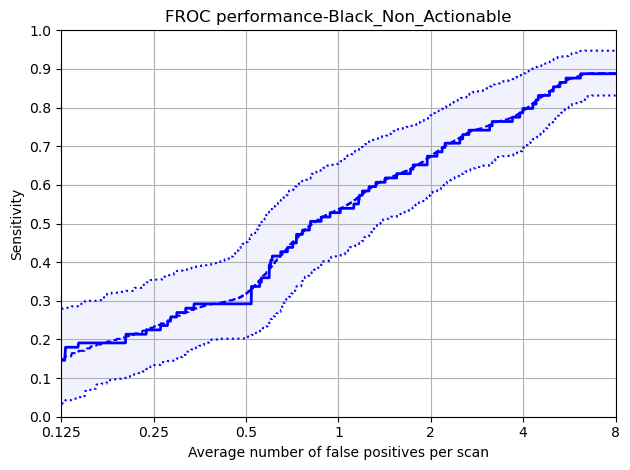

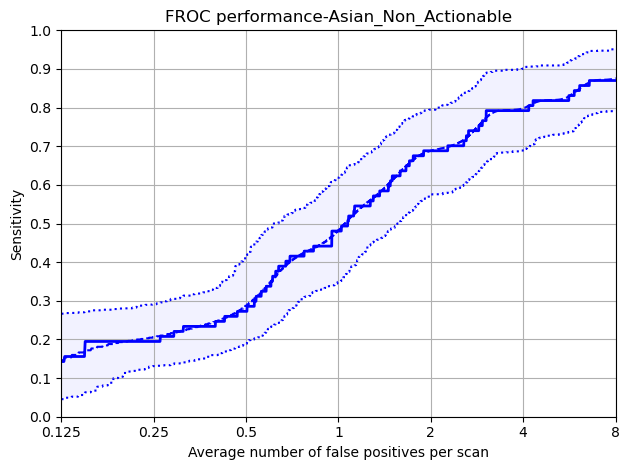

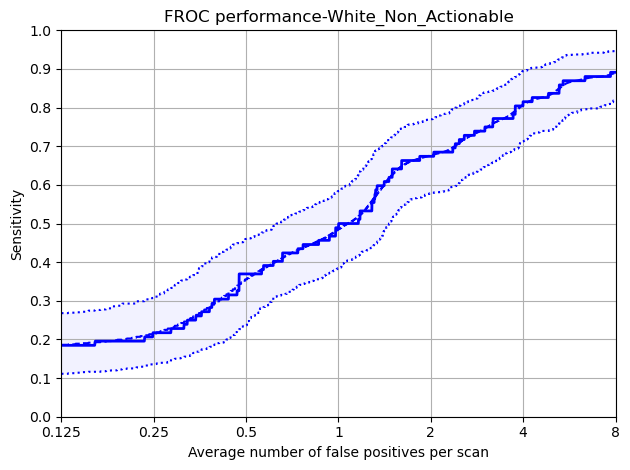

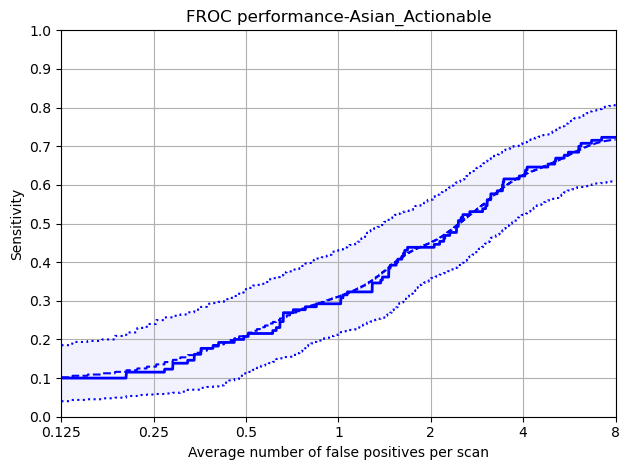

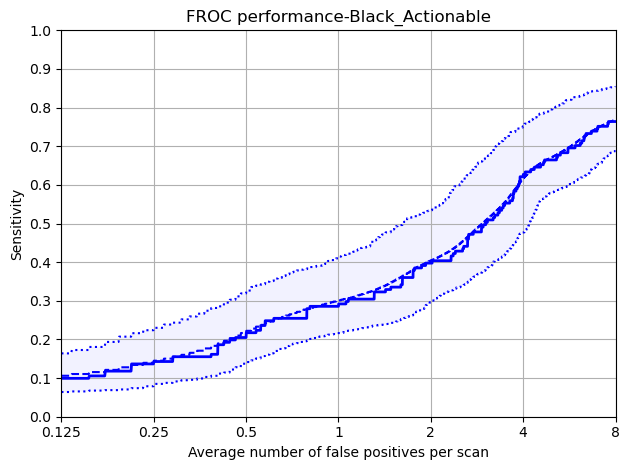

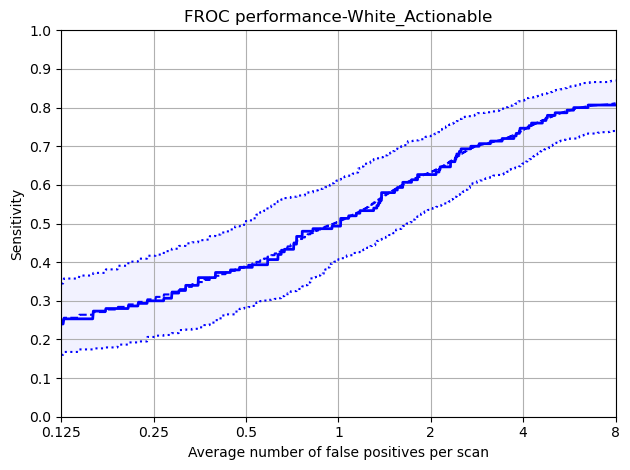

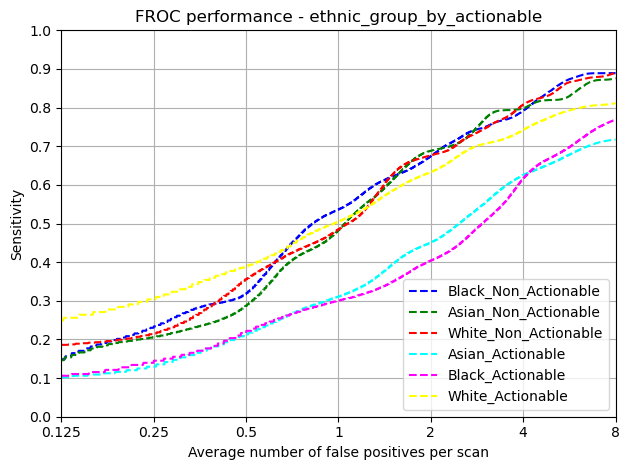

In [ ]:
protected_group = 'ethnic_group_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/test_balanced/{protected_group}'
)

In [ ]:
protected_group = 'ethnic_group_is_not_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/grt123/trained_summit/summit/test_balanced/{protected_group}'
)

### False positive and Miss Investigations

In [ ]:
thresholds = get_thresholds(grt123_summit_summit)
missed_metadata = miss_anaysis_at_fpps(
    scans_path=f'{workspace_path}/metadata/summit/partial/test_scans.csv',
    annotations_path=f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_metadata.csv',
    exclusions_path=f'{workspace_path}/data/summit/metadata/grt123_annotations_excluded_empty.csv',
    predictions_path=f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_predictions.csv',
    thresholds=thresholds
)


/Users/john/Projects/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_metadata.csv
Total number of included nodule annotations: 112
Total number of nodule annotations: 112
Cases: 892
Missed Annotations at 7.2206535 FPPs: 94
/Users/john/Projects/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_metadata.csv
Total number of included nodule annotations: 112
Total number of nodule annotations: 112
Cases: 892
Missed Annotations at 6.7395515 FPPs: 86
/Users/john/Projects/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_metadata.csv
Total number of included nodule annotations: 112
Total number of nodule annotations: 112
Cases: 892
Missed Annotations at 6.1739454 FPPs: 79
/Users/john/Projects/SOTAEvaluationNoduleDetection/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_metadata.csv
Total number of i

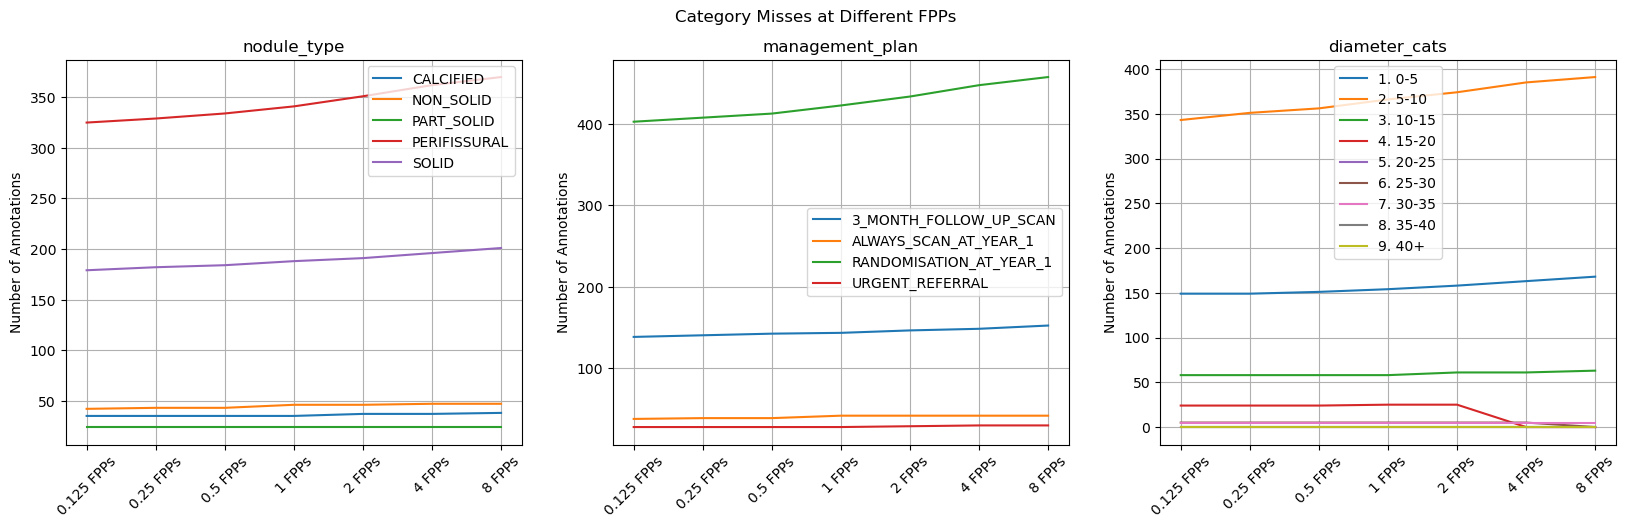

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for ivx, var in enumerate(['nodule_type','management_plan','diameter_cats']):
    annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_metadata.csv')
    total_vc = annotations[var].value_counts().sort_index().rename('Total Annotations')

    operating_points = ['0.125', '0.25', '0.5', '1', '2', '4', '8']

    results = []
    for idx, metadata in enumerate(missed_metadata):
        vc = metadata[var].value_counts().sort_index()

        results.append((total_vc - vc).rename(f'{operating_points[idx]} FPPs'))

    df = pd.concat(results, axis=1).fillna(0).round(2)

    for column in df.T:
        ax[ivx].plot(df.T[column], label=column)
    
    ax[ivx].set_xticklabels(labels=df.columns, rotation=45)
    ax[ivx].set_title(var)
    ax[ivx].legend()
    ax[ivx].set_ylabel('Number of Annotations')
    ax[ivx].grid(visible=True, which='both')

plt.suptitle('Category Misses at Different FPPs')
plt.show()

In [ ]:
thresholds = get_thresholds(grt123_summit_summit)

scans = pd.read_csv(f'{workspace_path}/metadata/summit/test_balanced/test_scans.csv')
predictions = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_predictions.csv')
annotations = pd.read_csv(f'{workspace_path}/models/grt123/bbox_result/trained_summit/summit/test_balanced/test_balanced_metadata.csv')

false_positives_fpps = false_positive_analysis(
    thresholds=thresholds,    
    predictions=predictions,
    annotations=annotations
)

predictions: 178 at threshold: 7.2206535
distance false positives: 73 at threshold: 7.2206535
predictions: 290 at threshold: 6.7395515
distance false positives: 145 at threshold: 6.7395515
predictions: 495 at threshold: 6.1739454
distance false positives: 292 at threshold: 6.1739454
predictions: 886 at threshold: 5.448881
distance false positives: 594 at threshold: 5.448881
predictions: 1595 at threshold: 4.5769815
distance false positives: 1205 at threshold: 4.5769815
predictions: 2922 at threshold: 3.3151371
distance false positives: 2415 at threshold: 3.3151371
predictions: 5326 at threshold: 1.4922369
distance false positives: 4744 at threshold: 1.4922369


summit-2477-ppd_Y0_BASELINE_A already exists
[[176.195       67.59        61.92         4.18984227]
 [ 99.015       51.19        31.24         5.00077949]
 [229.975      139.76        97.01        21.96288288]]
summit-2477-ppd_Y0_BASELINE_A - 241.58118 141.58931 93.29571 24.342207
False Positive: True
IoU False Positive: 0.2618061935096805


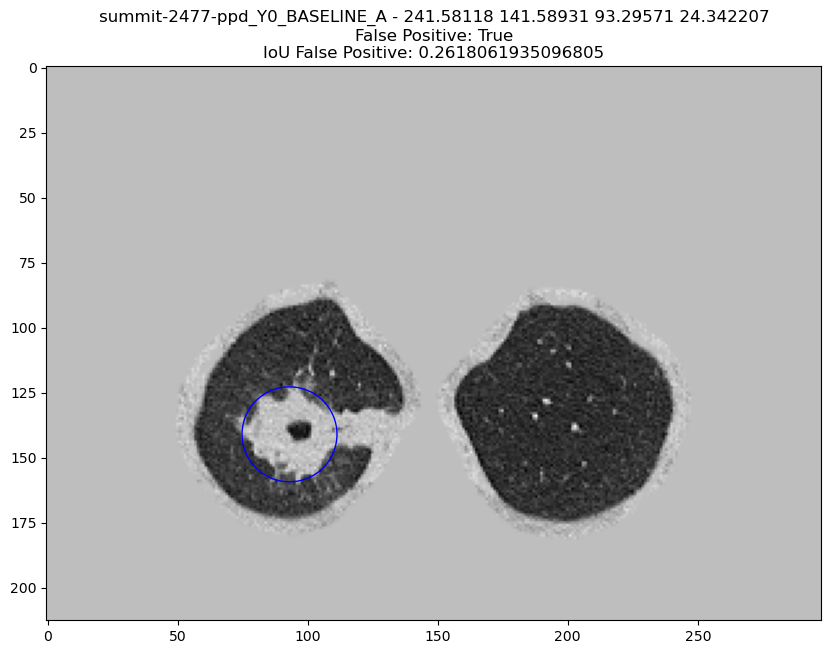

summit-4578-scm_Y0_BASELINE_A already exists
[[0 0 0 0]]
summit-4578-scm_Y0_BASELINE_A - 201.61537 209.58585 69.32576 24.454403
False Positive: True
IoU False Positive: nan


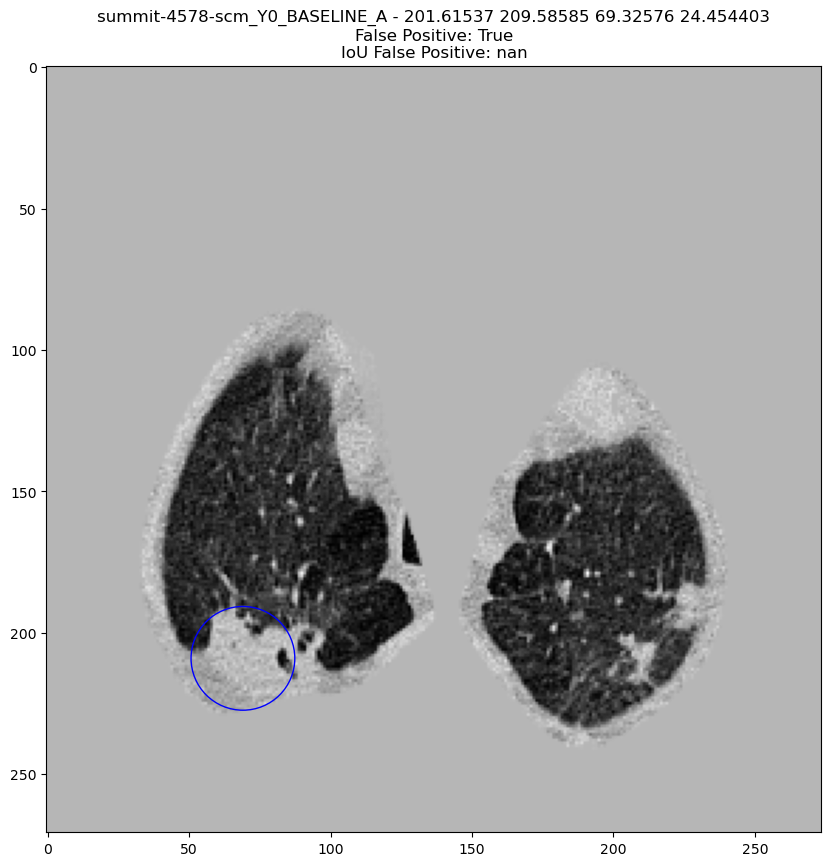

summit-4978-anz_Y0_BASELINE_A already exists
[[0 0 0 0]]
summit-4978-anz_Y0_BASELINE_A - 202.30933 73.39236 96.555664 8.925204
False Positive: True
IoU False Positive: nan


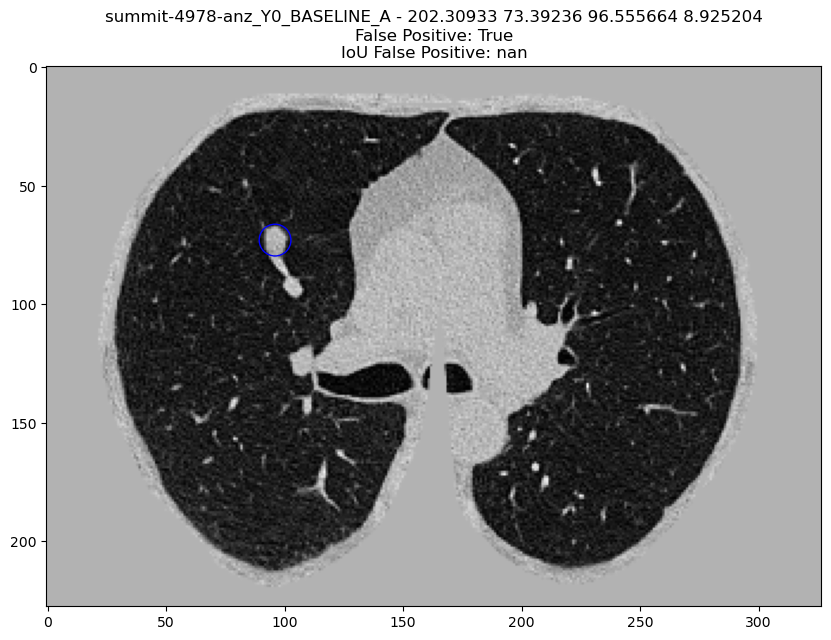

summit-9326-jcf_Y0_BASELINE_A already exists
[[156.21        80.37999695 266.2399939    2.553125  ]]
summit-9326-jcf_Y0_BASELINE_A - 57.027893 156.91324 17.563618 6.8193555
False Positive: True
IoU False Positive: 0.0


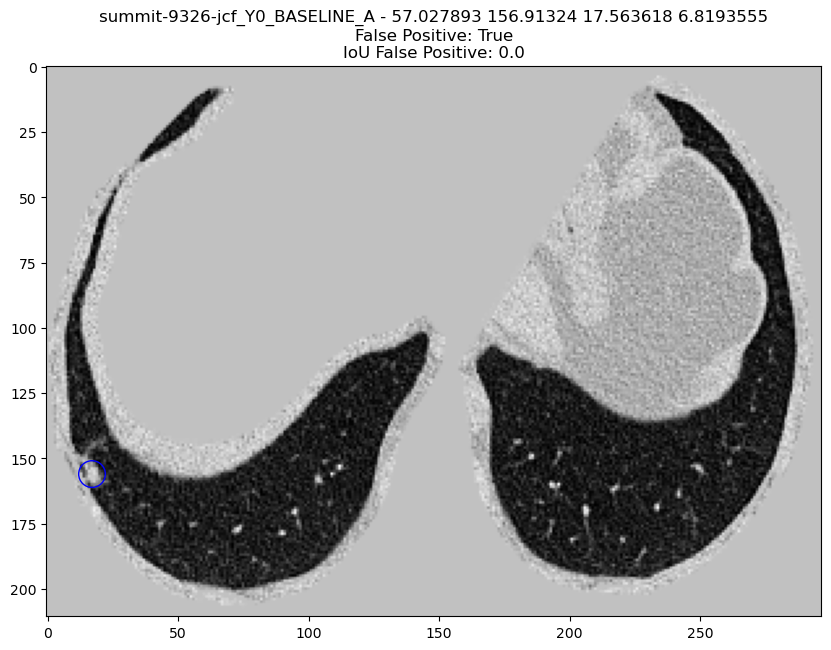

summit-3288-gfs_Y0_BASELINE_A already exists
[[0 0 0 0]]
summit-3288-gfs_Y0_BASELINE_A - 114.35067 176.82104 84.20917 8.196819
False Positive: True
IoU False Positive: nan


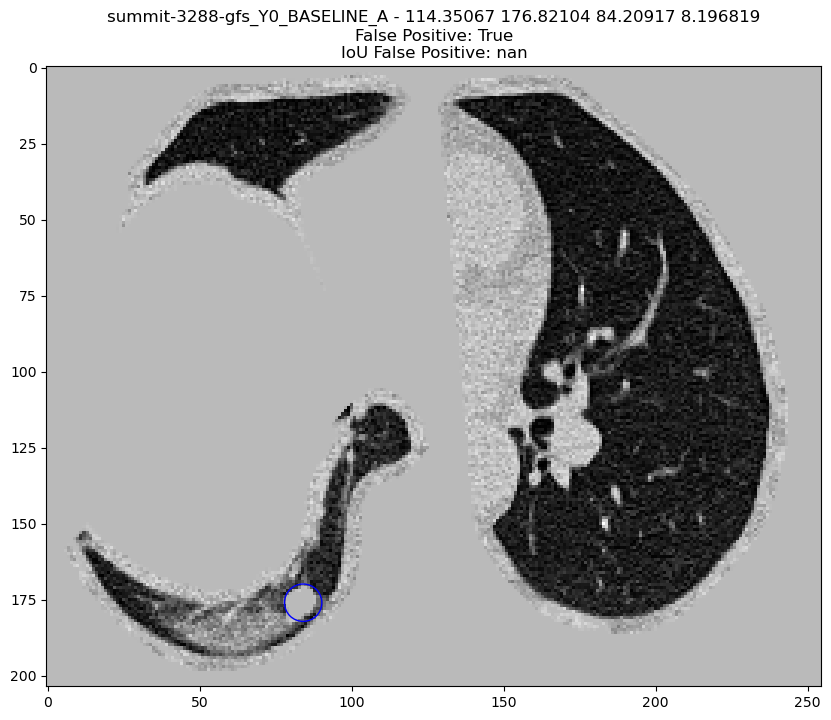

summit-3768-mgu_Y0_BASELINE_A already exists
[[131.88        92.94        92.2900061   19.00391288]]
summit-3768-mgu_Y0_BASELINE_A - 125.63948 77.64349 69.46979 26.383251
False Positive: True
IoU False Positive: 0.04573147508192739


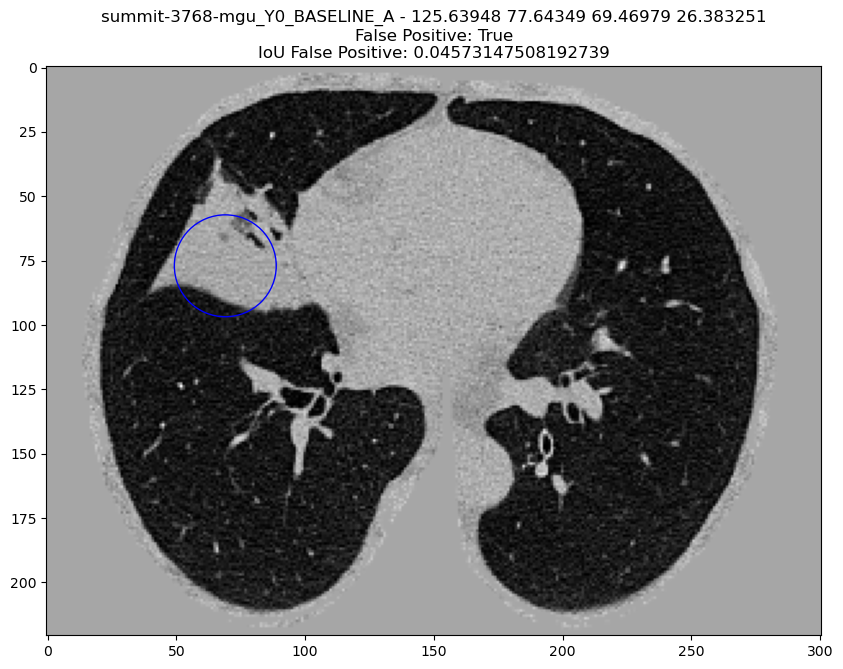

summit-9294-yyy_Y0_BASELINE_A already exists
[[0 0 0 0]]
summit-9294-yyy_Y0_BASELINE_A - 150.34537 101.987946 50.68444 5.7515306
False Positive: True
IoU False Positive: nan


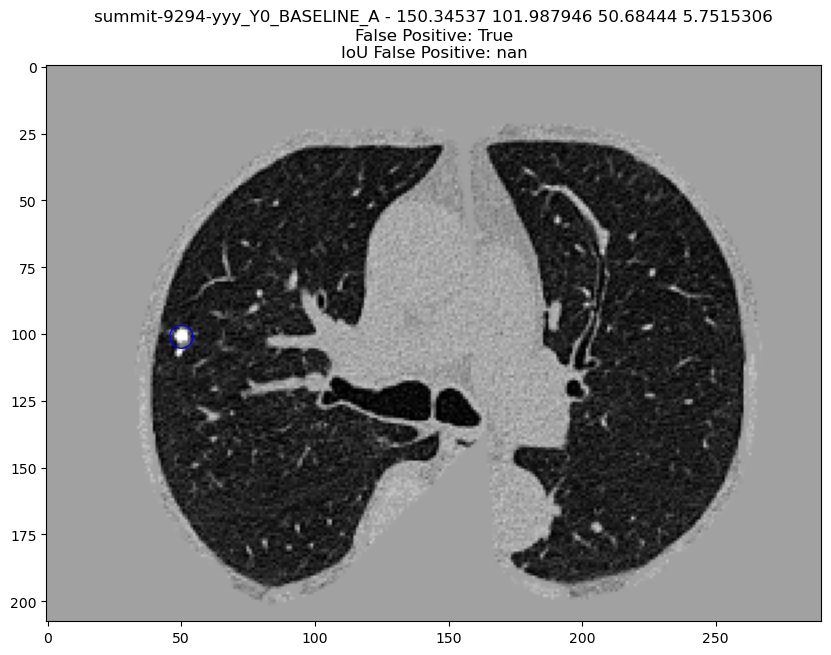

summit-9397-wse_Y0_BASELINE_A already exists
[[0 0 0 0]]
summit-9397-wse_Y0_BASELINE_A - 242.23856 49.40045 120.402115 10.403505
False Positive: True
IoU False Positive: nan


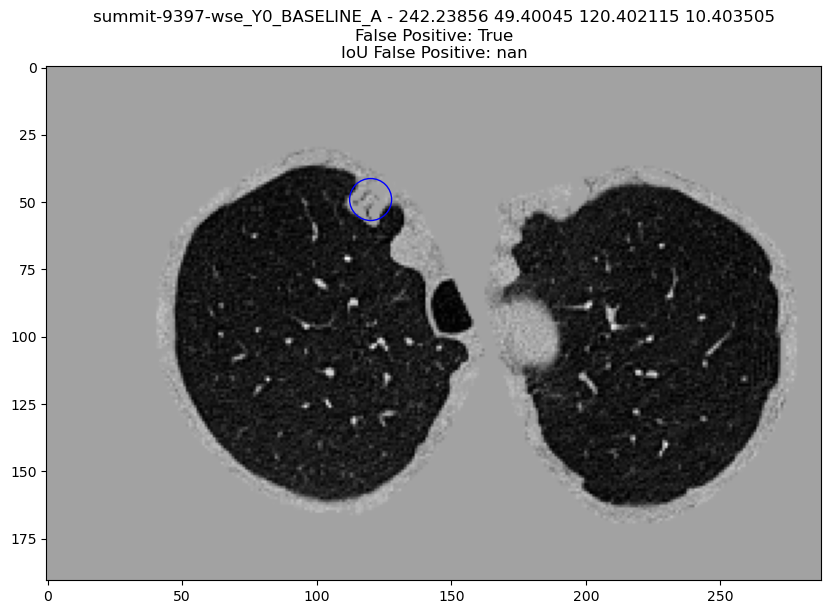

summit-3638-yab_Y0_BASELINE_A already exists
[[0 0 0 0]]
summit-3638-yab_Y0_BASELINE_A - 126.52324 34.375774 82.235794 5.4221
False Positive: True
IoU False Positive: nan


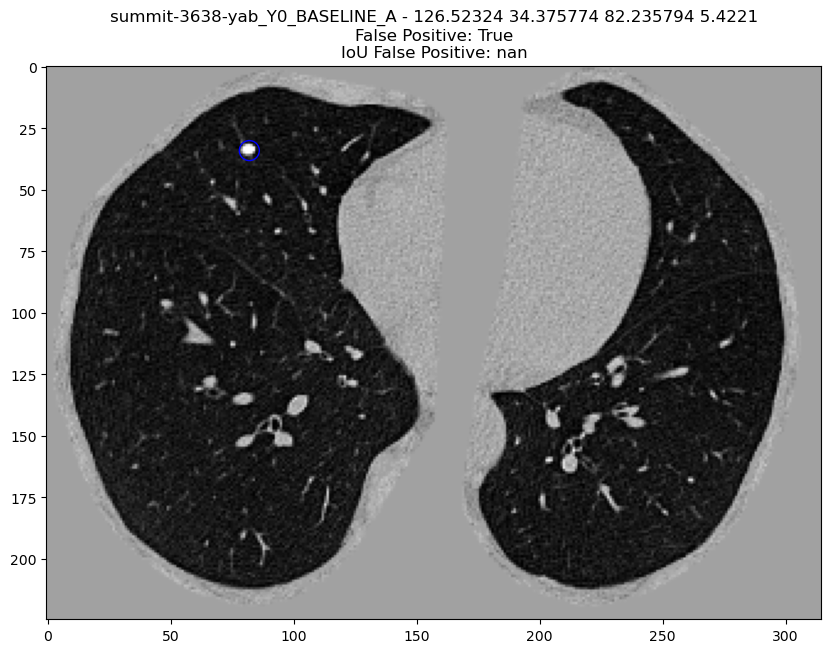

summit-7962-cga_Y0_BASELINE_A already exists
[[58.61       59.11       23.84999695  8.27734685]]
summit-7962-cga_Y0_BASELINE_A - 222.75877 65.44562 97.234245 6.424183
False Positive: True
IoU False Positive: 0.0


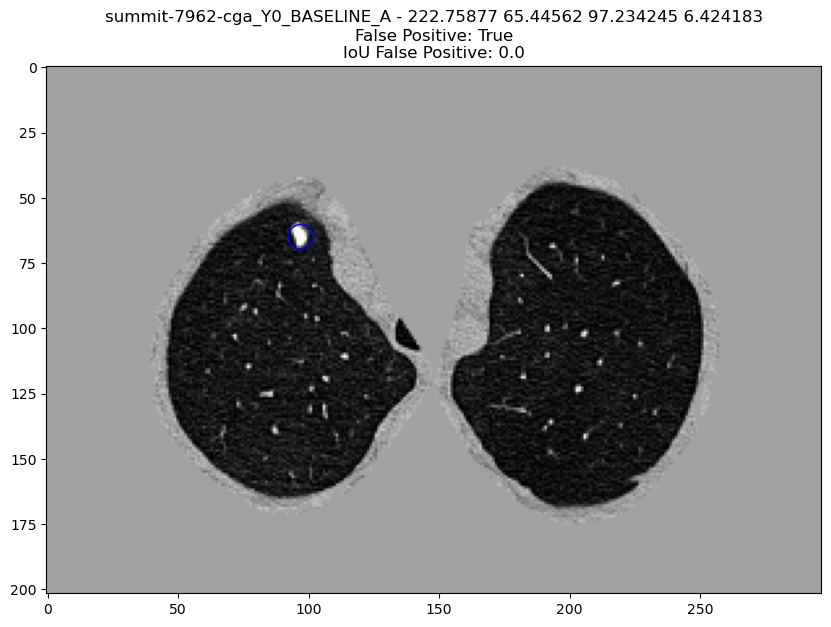

summit-8563-tkf_Y0_BASELINE_A already exists
[[191.805      181.65       104.0799939    4.66288898]
 [177.555      195.03        69.4099939    3.51406126]]
summit-8563-tkf_Y0_BASELINE_A - 100.78754 57.05622 277.118 6.998582
False Positive: True
IoU False Positive: 0.0


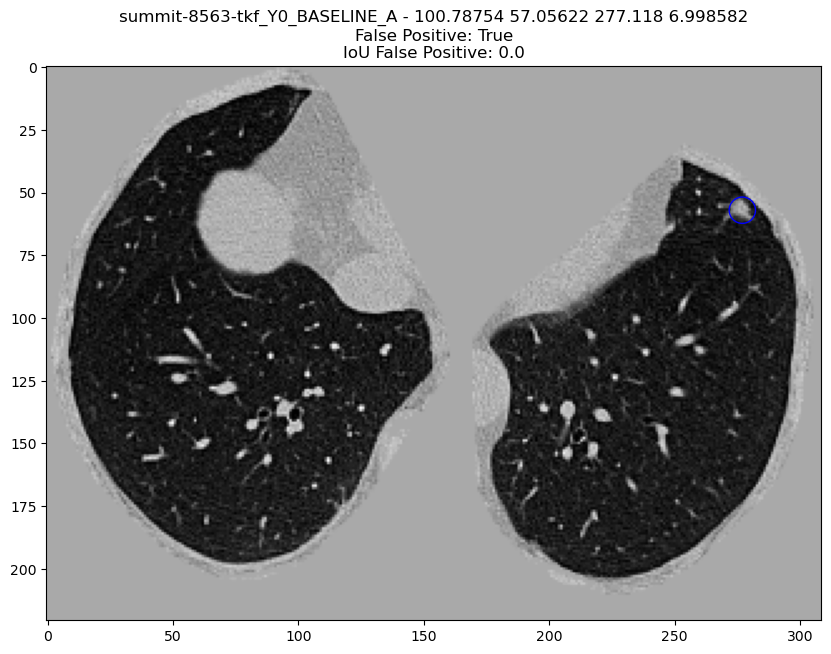

summit-8799-hac_Y0_BASELINE_A already exists
[[102.975     116.7        15.03        3.0234375]
 [119.235     122.65      281.93        2.53125  ]
 [162.955     184.76      191.36        4.1484375]
 [170.705     191.2       201.82        3.1640625]]
summit-8799-hac_Y0_BASELINE_A - 57.271576 164.68388 184.4122 6.879239
False Positive: True
IoU False Positive: 0.0


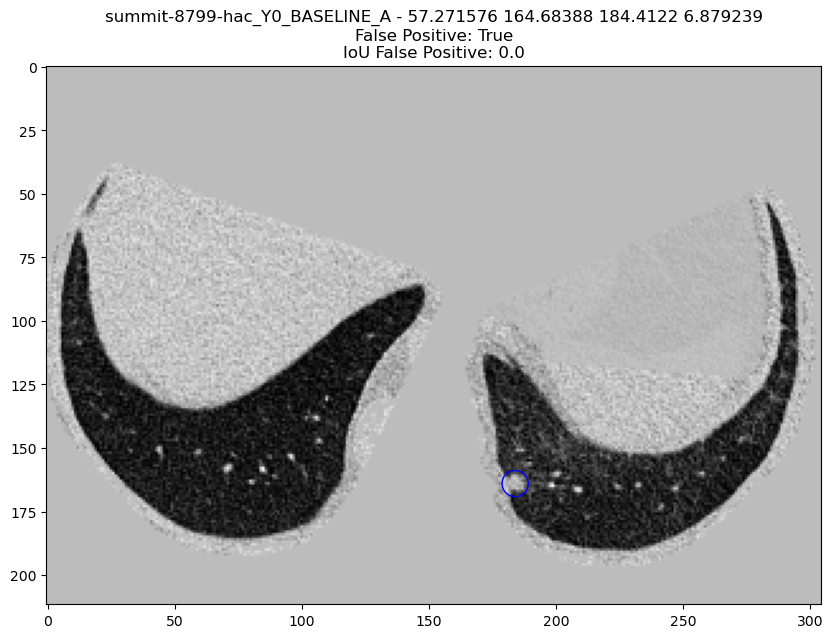

In [ ]:
cnt = 0

df = false_positives_fpps['0.125']

for idx, row in df[df.distance_false_positive].sort_values(by='threshold', ascending=False).iterrows():
    study_id = row['name']
    x = row['row']
    y = row['col']
    z = row['index']
    diameter = row['diameter']
    

    copy_scan_from_cluster(study_id)
    show_numpy_candidate_location(study_id, x, y, z, diameter, row.distance_false_positive, row.iou_false_positive)
    cnt+=1
    if cnt == 12:
        break

## MONAI Detection

/Users/john/Projects/SOTAEvaluationNoduleDetection/models/detection/result/trained_summit/summit/test_balanced/result_test_balanced.json
/Users/john/Projects/SOTAEvaluationNoduleDetection/models/detection/result/trained_summit/summit/test_balanced/annotations.csv
Total number of included nodule annotations: 699
Total number of nodule annotations: 699
Cases: 595
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-2323-kha_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-2323-kha_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:26<00:00, 37.57it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.22      0.17       0.27
159   0.25       0.34      0.29       0.40
476   0.50       0.48      0.42       0.53
1111  1.00       0.61      0.56       0.66
2381  2.00       0.73      0.69       0.77
4920  4.00       0.84      0.81       0.88
9999  8.00       0.91      0.89       0.94

Mean Sensitivity: 0.59 Low Sensitivity: 0.55 High Sensitivity: 0.64


True positives        672
0                                    False positives  23403.000
1                                    False negatives     27.000
2                                     True negatives      0.000
3                         Total number of candidates  24768.000
4                            Total number of nodules    699.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    698.000
7                                        Sensitivity      0.961
8              Average number of candidates per scan     41.627

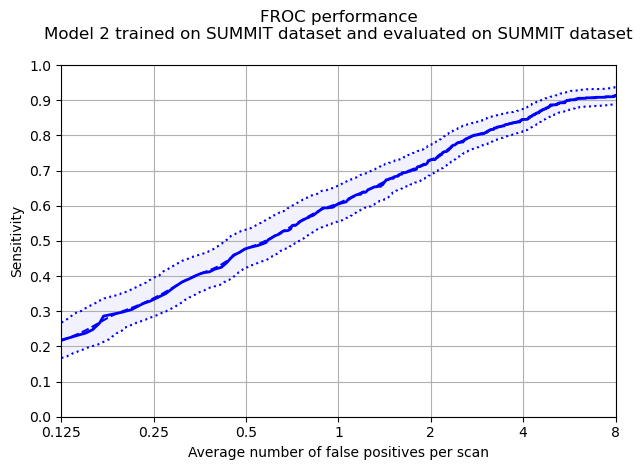

In [ ]:

detection_predictions_path = combine_predictions(f'{workspace_path}/models/detection/result/trained_summit/summit/test_balanced', 'test')
detection_predictions = pd.read_csv(detection_predictions_path)

annotations = (
    pd.read_csv(f'{workspace_path}/metadata/summit/test_balanced/test_metadata.csv')
    .assign(name=lambda df: df.participant_id + '_Y0_BASELINE_A')
    .assign(row=lambda df: df['nodule_x_coordinate'])
    .assign(col=lambda df: df['nodule_y_coordinate'])
    .assign(index=lambda df: df['nodule_z_coordinate'])
    .assign(diameter=lambda df: df['nodule_diameter_mm'])
    .assign(diameter_cats=lambda df: pd.cut(
        df['nodule_diameter_mm'],
        bins=[0, 5, 10, 15, 20, 25, 30, 35, 40, 999],
        labels=['1. 0-5', '2. 5-10', '3. 10-15', '4. 15-20', '5. 20-25', '6. 25-30', '7. 30-35', '8. 35-40', '9. 40+']
    ))
)

annotations.to_csv(f'{workspace_path}/models/detection/result/trained_summit/summit/test_balanced/annotations.csv', index=False)

detection_summit_summit = noduleCADEvaluation(
    annotations_filename=f'{workspace_path}/models/detection/result/trained_summit/summit/test_balanced/annotations.csv',
    annotations_excluded_filename=f'{workspace_path}/data/summit/metadata/annotations_excluded_empty.csv',
    seriesuids_filename=f'{workspace_path}/metadata/summit/test_balanced/test_scans.csv',
    results_filename=detection_predictions_path,
    filter='\nModel 2 trained on SUMMIT dataset and evaluated on SUMMIT dataset\n',
    outputDir=f'{workspace_path}/results/detection/trained_summit/summit/test_balanced',
)
caluclate_cpm_from_bootstrapping(f'{workspace_path}/results/detection/trained_summit/summit/test_balanced/froc_predictions_bootstrapping.csv')
show_metrics(f'{workspace_path}/results/detection/trained_summit/summit/test_balanced/CADAnalysis.txt')


### Gender analysis

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpdn31lcj4/annotations.csv
Total number of included nodule annotations: 400
Total number of nodule annotations: 400
Cases: 345
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-2323-kha_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-2323-kha_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:13<00:00, 71.46it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.19      0.13       0.26
159   0.25       0.32      0.25       0.39
476   0.50       0.47      0.40       0.54
1111  1.00       0.60      0.53       0.67
2381  2.00       0.72      0.66       0.78
4920  4.00       0.84      0.79       0.88
9999  8.00       0.92      0.88       0.95

Mean Sensitivity: 0.58 Low Sensitivity: 0.52 High Sensitivity: 0.64


True positives        387
0                                    False positives  13796.000
1                                    False negatives     13.000
2                                     True negatives      0.000
3                         Total number of candidates  14542.000
4                            Total number of nodules    400.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    361.000
7                                        Sensitivity      0.968
8              Average number of candidates per scan     42.151

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpwhgarqtb/annotations.csv
Total number of included nodule annotations: 299
Total number of nodule annotations: 299
Cases: 251
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:09<00:00, 108.42it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.25      0.18       0.34
159   0.25       0.37      0.30       0.44
476   0.50       0.49      0.41       0.57
1111  1.00       0.62      0.55       0.69
2381  2.00       0.75      0.69       0.81
4920  4.00       0.86      0.82       0.90
9999  8.00       0.91      0.88       0.94

Mean Sensitivity: 0.61 Low Sensitivity: 0.55 High Sensitivity: 0.67


True positives        285
0                                    False positives   9607.000
1                                    False negatives     14.000
2                                     True negatives      0.000
3                         Total number of candidates  10226.000
4                            Total number of nodules    299.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    337.000
7                                        Sensitivity      0.953
8              Average number of candidates per scan     40.741

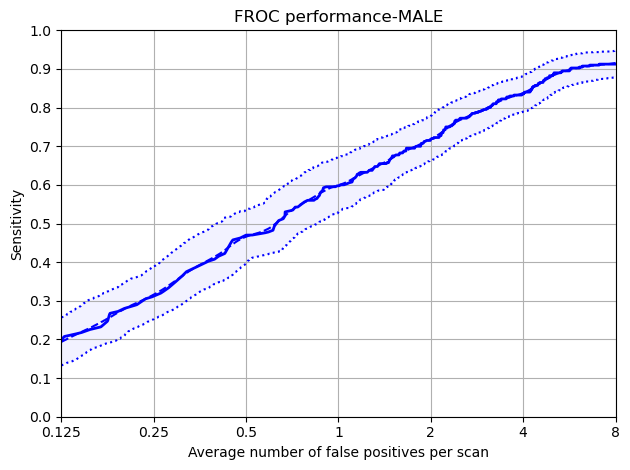

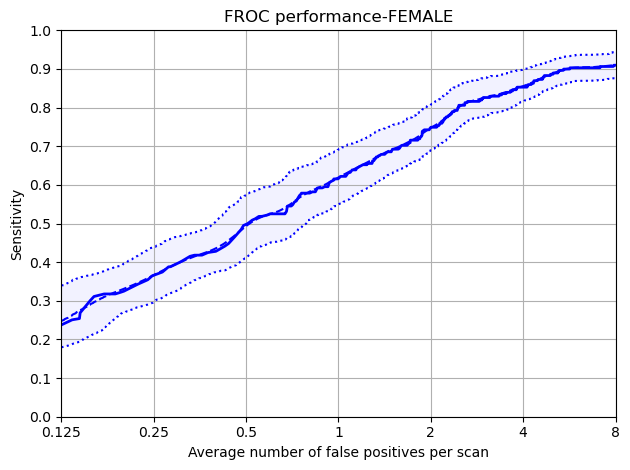

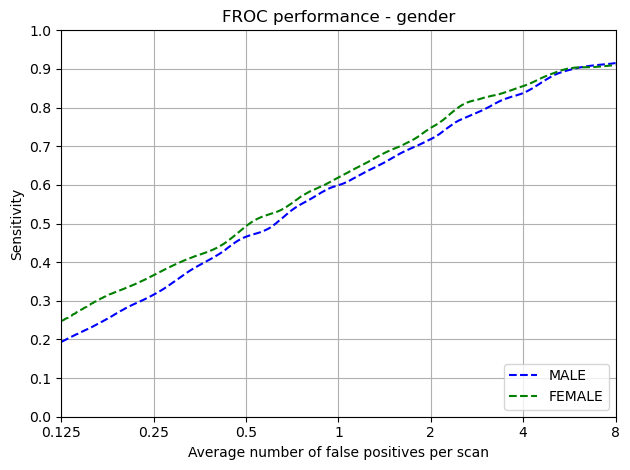

In [ ]:


annotations = pd.read_csv(f'{workspace_path}/models/detection/result/trained_summit/summit/test_balanced/annotations.csv')

predictions = pd.read_csv(detection_predictions_path)

protected_group = 'gender'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/test_balanced/{protected_group}'
)

### Ethnicity Analysis

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpiruzf1j3/annotations.csv
Total number of included nodule annotations: 250
Total number of nodule annotations: 250
Cases: 199


100%|██████████| 1000/1000 [00:07<00:00, 132.61it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.27      0.18       0.36
159   0.25       0.33      0.25       0.44
476   0.50       0.46      0.38       0.56
1111  1.00       0.59      0.51       0.69
2381  2.00       0.73      0.67       0.81
4920  4.00       0.84      0.79       0.89
9999  8.00       0.92      0.88       0.95

Mean Sensitivity: 0.59 Low Sensitivity: 0.52 High Sensitivity: 0.67


True positives       241
0                                    False positives  7539.000
1                                    False negatives     9.000
2                                     True negatives     0.000
3                         Total number of candidates  7993.000
4                            Total number of nodules   250.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...   213.000
7                                        Sensitivity     0.964
8              Average number of candidates per scan    40.166

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpyg3_ney2/annotations.csv
Total number of included nodule annotations: 207
Total number of nodule annotations: 207
Cases: 199
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-2323-kha_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-2323-kha_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:07<00:00, 130.30it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.19      0.11       0.27
159   0.25       0.31      0.20       0.45
476   0.50       0.48      0.39       0.58
1111  1.00       0.61      0.52       0.70
2381  2.00       0.71      0.63       0.79
4920  4.00       0.83      0.76       0.90
9999  8.00       0.90      0.84       0.95

Mean Sensitivity: 0.58 Low Sensitivity: 0.49 High Sensitivity: 0.66


True positives       195
0                                    False positives  7673.000
1                                    False negatives    12.000
2                                     True negatives     0.000
3                         Total number of candidates  8039.000
4                            Total number of nodules   207.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...   173.000
7                                        Sensitivity     0.942
8              Average number of candidates per scan    40.397

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpqirf1z0x/annotations.csv
Total number of included nodule annotations: 242
Total number of nodule annotations: 242
Cases: 199
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:07<00:00, 125.23it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.22      0.14       0.32
159   0.25       0.35      0.27       0.42
476   0.50       0.48      0.40       0.56
1111  1.00       0.63      0.55       0.70
2381  2.00       0.76      0.69       0.82
4920  4.00       0.86      0.82       0.91
9999  8.00       0.93      0.89       0.96

Mean Sensitivity: 0.6 Low Sensitivity: 0.54 High Sensitivity: 0.67


True positives       236
0                                    False positives  8191.000
1                                    False negatives     6.000
2                                     True negatives     0.000
3                         Total number of candidates  8736.000
4                            Total number of nodules   242.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...   312.000
7                                        Sensitivity     0.975
8              Average number of candidates per scan    43.899

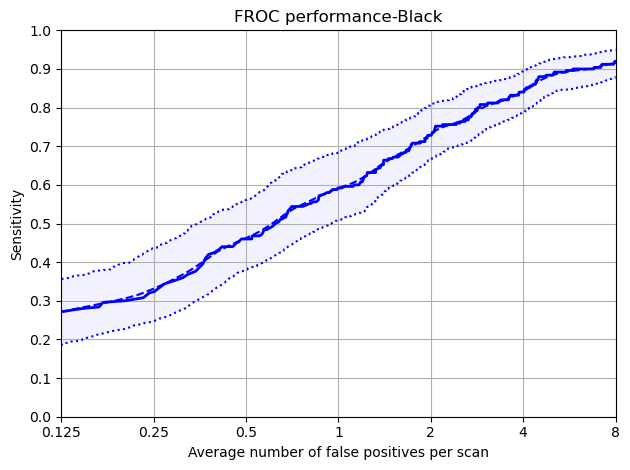

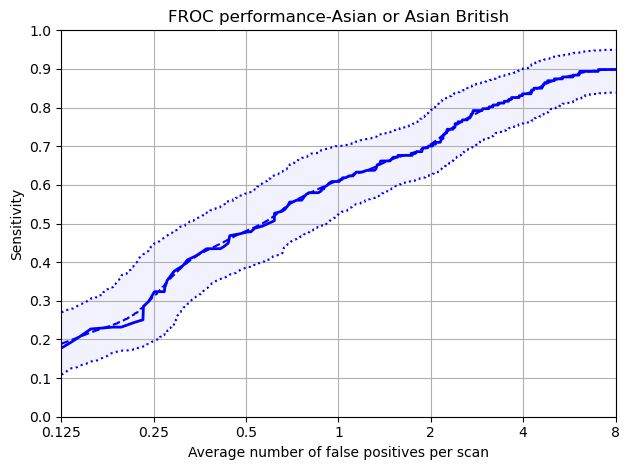

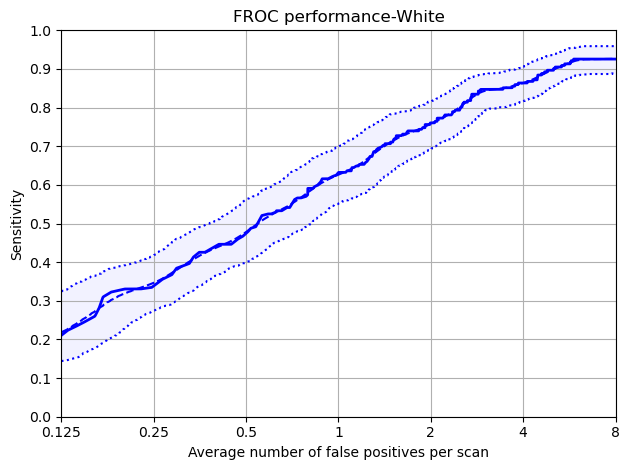

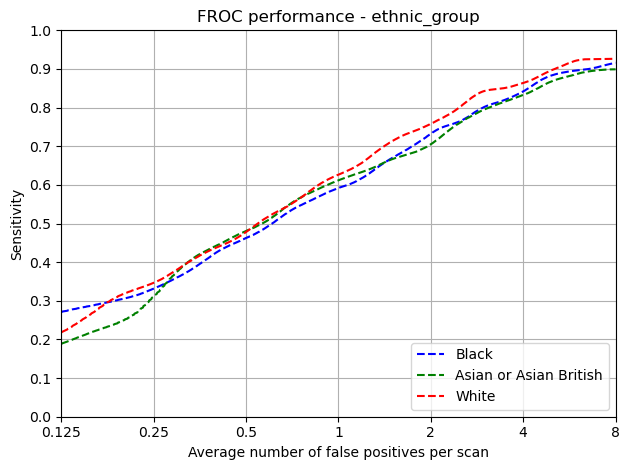

In [ ]:
protected_group = 'ethnic_group'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/test_balanced/{protected_group}'
)

### Is Actionable

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp0y_g5ywa/annotations.csv
Total number of included nodule annotations: 258
Total number of nodule annotations: 258
Cases: 424
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:15<00:00, 64.12it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.28      0.21       0.36
159   0.25       0.41      0.34       0.49
476   0.50       0.58      0.52       0.65
1111  1.00       0.73      0.67       0.78
2381  2.00       0.85      0.80       0.91
4920  4.00       0.94      0.91       0.97
9999  8.00       0.97      0.94       0.99

Mean Sensitivity: 0.68 Low Sensitivity: 0.63 High Sensitivity: 0.74


True positives        254
0                                    False positives  15030.000
1                                    False negatives      4.000
2                                     True negatives      0.000
3                         Total number of candidates  15434.000
4                            Total number of nodules    258.000
5             Ignored candidates on excluded nodules      0.000
6      Ignored candidates which were double detec...    153.000
7                                        Sensitivity      0.984
8              Average number of candidates per scan     36.401

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmphyxerfk2/annotations.csv
Total number of included nodule annotations: 441
Total number of nodule annotations: 441
Cases: 172
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-2323-kha_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-2323-kha_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:08<00:00, 123.87it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.18      0.13       0.28
159   0.25       0.30      0.22       0.38
476   0.50       0.39      0.32       0.47
1111  1.00       0.52      0.46       0.60
2381  2.00       0.64      0.58       0.70
4920  4.00       0.77      0.71       0.81
9999  8.00       0.87      0.83       0.91

Mean Sensitivity: 0.52 Low Sensitivity: 0.46 High Sensitivity: 0.59


True positives       418
0                                    False positives  8373.000
1                                    False negatives    23.000
2                                     True negatives     0.000
3                         Total number of candidates  9334.000
4                            Total number of nodules   441.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...   545.000
7                                        Sensitivity     0.948
8              Average number of candidates per scan    54.267

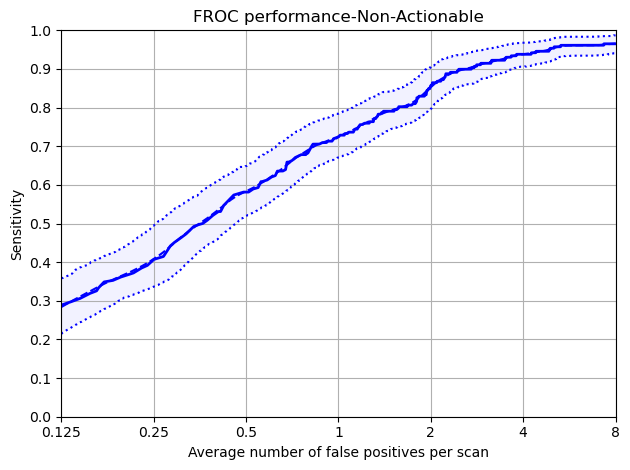

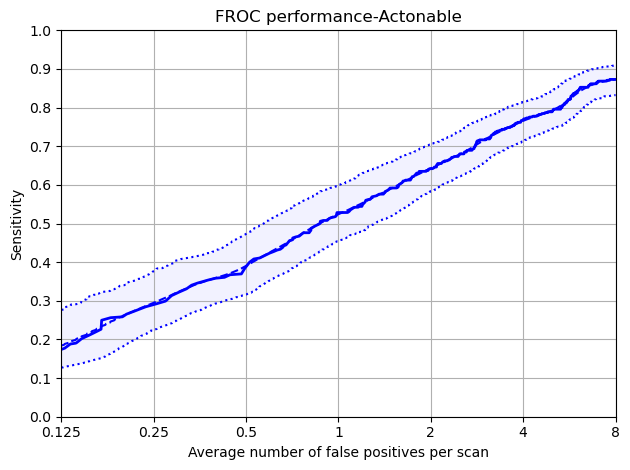

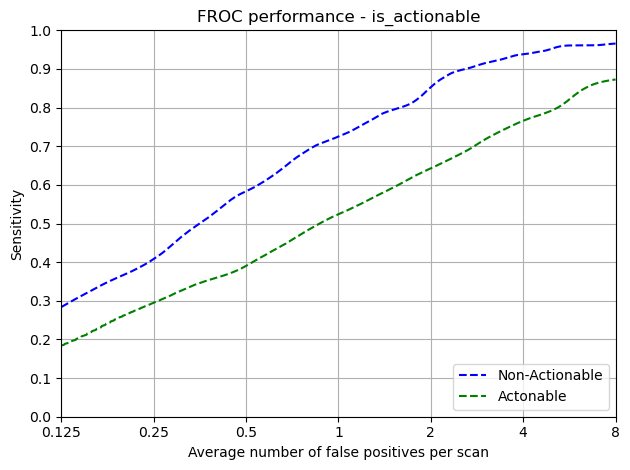

In [ ]:
protected_group = 'is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/test_balanced/{protected_group}'
)

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpavtk3ej4/annotations.csv
Total number of included nodule annotations: 137
Total number of nodule annotations: 137
Cases: 254


100%|██████████| 1000/1000 [00:08<00:00, 112.38it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.30      0.19       0.41
159   0.25       0.45      0.36       0.56
476   0.50       0.59      0.51       0.68
1111  1.00       0.76      0.69       0.83
2381  2.00       0.87      0.79       0.94
4920  4.00       0.95      0.91       0.99
9999  8.00       0.97      0.94       0.99

Mean Sensitivity: 0.7 Low Sensitivity: 0.63 High Sensitivity: 0.77


True positives       135
0                                    False positives  9129.000
1                                    False negatives     2.000
2                                     True negatives     0.000
3                         Total number of candidates  9347.000
4                            Total number of nodules   137.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    83.000
7                                        Sensitivity     0.985
8              Average number of candidates per scan    36.799

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpl80bup6c/annotations.csv
Total number of included nodule annotations: 121
Total number of nodule annotations: 121
Cases: 171
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:05<00:00, 174.32it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.26      0.17       0.36
159   0.25       0.37      0.27       0.49
476   0.50       0.57      0.45       0.67
1111  1.00       0.69      0.60       0.77
2381  2.00       0.83      0.75       0.90
4920  4.00       0.92      0.87       0.97
9999  8.00       0.96      0.92       0.99

Mean Sensitivity: 0.66 Low Sensitivity: 0.58 High Sensitivity: 0.74


True positives       119
0                                    False positives  5901.000
1                                    False negatives     2.000
2                                     True negatives     0.000
3                         Total number of candidates  6087.000
4                            Total number of nodules   121.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    70.000
7                                        Sensitivity     0.983
8              Average number of candidates per scan    35.596

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp3nukxibh/annotations.csv
Total number of included nodule annotations: 263
Total number of nodule annotations: 263
Cases: 92
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-2323-kha_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-2323-kha_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:04<00:00, 215.35it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.15      0.06       0.25
159   0.25       0.24      0.15       0.35
476   0.50       0.36      0.26       0.47
1111  1.00       0.49      0.40       0.60
2381  2.00       0.62      0.53       0.71
4920  4.00       0.74      0.66       0.82
9999  8.00       0.87      0.81       0.92

Mean Sensitivity: 0.5 Low Sensitivity: 0.41 High Sensitivity: 0.59


True positives       252
0                                    False positives  4667.000
1                                    False negatives    11.000
2                                     True negatives     0.000
3                         Total number of candidates  5195.000
4                            Total number of nodules   263.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...   278.000
7                                        Sensitivity     0.958
8              Average number of candidates per scan    56.467

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpjge40bsn/annotations.csv
Total number of included nodule annotations: 178
Total number of nodule annotations: 178
Cases: 81


100%|██████████| 1000/1000 [00:03<00:00, 270.72it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.26      0.16       0.38
159   0.25       0.37      0.28       0.46
476   0.50       0.44      0.34       0.55
1111  1.00       0.57      0.48       0.68
2381  2.00       0.68      0.60       0.77
4920  4.00       0.79      0.72       0.86
9999  8.00       0.87      0.82       0.92

Mean Sensitivity: 0.57 Low Sensitivity: 0.49 High Sensitivity: 0.66


True positives       166
0                                    False positives  3706.000
1                                    False negatives    12.000
2                                     True negatives     0.000
3                         Total number of candidates  4139.000
4                            Total number of nodules   178.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...   267.000
7                                        Sensitivity     0.933
8              Average number of candidates per scan    51.099

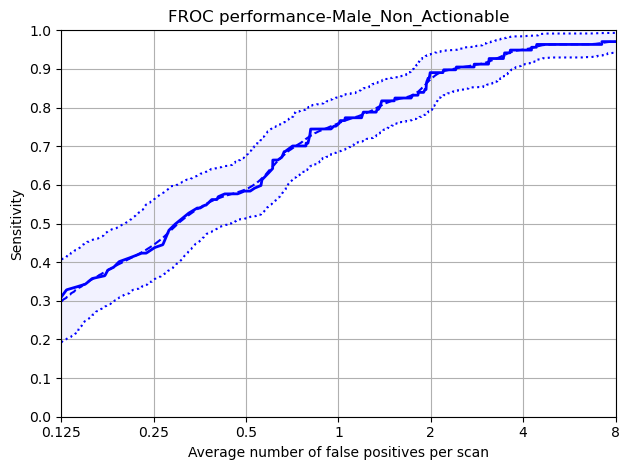

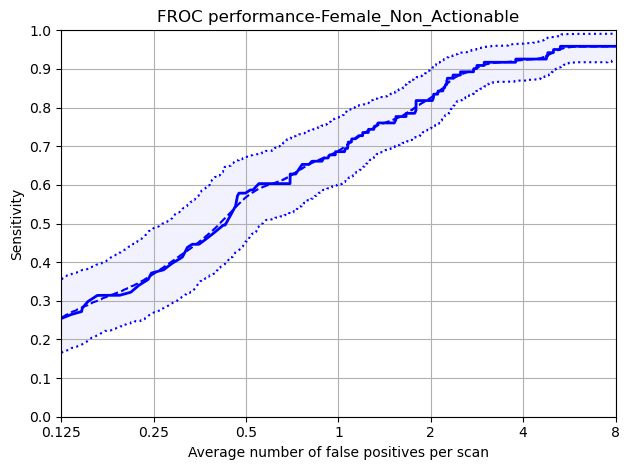

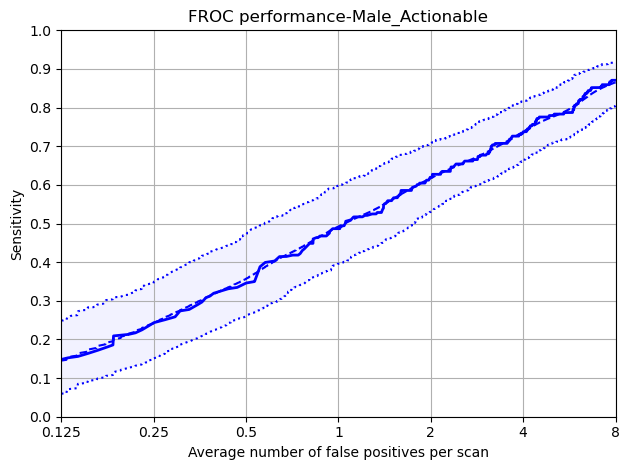

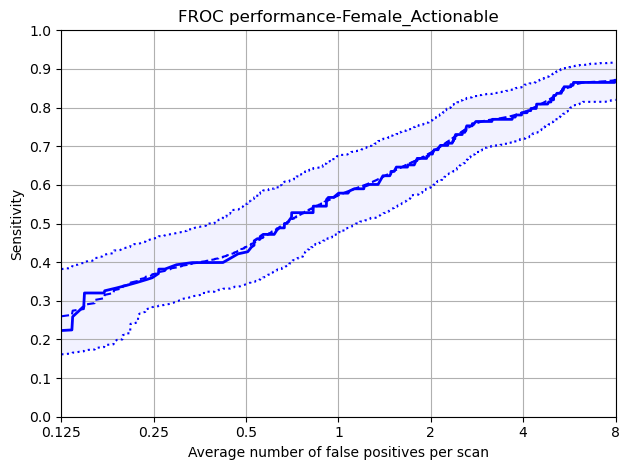

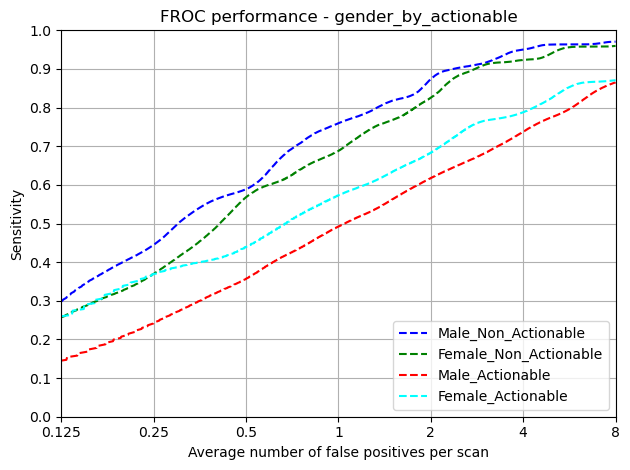

In [ ]:
protected_group = 'gender_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/test_balanced/{protected_group}'
)


In [ ]:
protected_group = 'gender_is_not_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/test_balanced/{protected_group}'
)

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmplkdi0bpn/annotations.csv
Total number of included nodule annotations: 89
Total number of nodule annotations: 89
Cases: 148


100%|██████████| 1000/1000 [00:05<00:00, 191.09it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.40      0.27       0.51
159   0.25       0.48      0.37       0.61
476   0.50       0.59      0.49       0.69
1111  1.00       0.70      0.61       0.79
2381  2.00       0.80      0.71       0.89
4920  4.00       0.90      0.83       0.96
9999  8.00       0.93      0.87       0.98

Mean Sensitivity: 0.69 Low Sensitivity: 0.59 High Sensitivity: 0.78


True positives        86
0                                    False positives  5200.000
1                                    False negatives     3.000
2                                     True negatives     0.000
3                         Total number of candidates  5330.000
4                            Total number of nodules    89.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    44.000
7                                        Sensitivity     0.966
8              Average number of candidates per scan    36.014

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpdetogbnr/annotations.csv
Total number of included nodule annotations: 77
Total number of nodule annotations: 77
Cases: 141


100%|██████████| 1000/1000 [00:05<00:00, 198.96it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.26      0.14       0.40
159   0.25       0.44      0.27       0.61
476   0.50       0.61      0.48       0.75
1111  1.00       0.76      0.66       0.85
2381  2.00       0.93      0.83       0.99
4920  4.00       0.97      0.93       1.00
9999  8.00       1.00      1.00       1.00

Mean Sensitivity: 0.71 Low Sensitivity: 0.62 High Sensitivity: 0.8


True positives        77
0                                    False positives  4869.000
1                                    False negatives     0.000
2                                     True negatives     0.000
3                         Total number of candidates  5001.000
4                            Total number of nodules    77.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    55.000
7                                        Sensitivity     1.000
8              Average number of candidates per scan    35.468

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpkghng4wy/annotations.csv
Total number of included nodule annotations: 92
Total number of nodule annotations: 92
Cases: 137
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-6683-wks_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:04<00:00, 209.39it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.22      0.13       0.34
159   0.25       0.35      0.25       0.45
476   0.50       0.50      0.37       0.64
1111  1.00       0.71      0.59       0.82
2381  2.00       0.83      0.75       0.92
4920  4.00       0.95      0.89       0.99
9999  8.00       0.97      0.93       1.00

Mean Sensitivity: 0.65 Low Sensitivity: 0.56 High Sensitivity: 0.74


True positives        91
0                                    False positives  4961.000
1                                    False negatives     1.000
2                                     True negatives     0.000
3                         Total number of candidates  5103.000
4                            Total number of nodules    92.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...    54.000
7                                        Sensitivity     0.989
8              Average number of candidates per scan    37.248

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp_mp5cj8g/annotations.csv
Total number of included nodule annotations: 130
Total number of nodule annotations: 130
Cases: 59
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-2323-kha_Y0_BASELINE_A, nodule Annot ID: None
This is strange: CAD mark None detected two nodules! Check for overlapping nodule annotations, SeriesUID: summit-2323-kha_Y0_BASELINE_A, nodule Annot ID: None


100%|██████████| 1000/1000 [00:02<00:00, 347.75it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.13      0.04       0.25
159   0.25       0.22      0.12       0.39
476   0.50       0.37      0.26       0.50
1111  1.00       0.49      0.37       0.62
2381  2.00       0.58      0.47       0.68
4920  4.00       0.69      0.56       0.80
9999  8.00       0.82      0.71       0.90

Mean Sensitivity: 0.47 Low Sensitivity: 0.36 High Sensitivity: 0.59


True positives       118
0                                    False positives  2804.000
1                                    False negatives    12.000
2                                     True negatives     0.000
3                         Total number of candidates  3038.000
4                            Total number of nodules   130.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...   118.000
7                                        Sensitivity     0.908
8              Average number of candidates per scan    51.492

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmpqmabbbeo/annotations.csv
Total number of included nodule annotations: 161
Total number of nodule annotations: 161
Cases: 52


100%|██████████| 1000/1000 [00:02<00:00, 398.00it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.20      0.09       0.31
159   0.25       0.24      0.15       0.36
476   0.50       0.34      0.21       0.49
1111  1.00       0.52      0.38       0.67
2381  2.00       0.67      0.56       0.79
4920  4.00       0.79      0.71       0.87
9999  8.00       0.90      0.84       0.95

Mean Sensitivity: 0.52 Low Sensitivity: 0.42 High Sensitivity: 0.63


True positives       155
0                                    False positives  2339.000
1                                    False negatives     6.000
2                                     True negatives     0.000
3                         Total number of candidates  2663.000
4                            Total number of nodules   161.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...   169.000
7                                        Sensitivity     0.963
8              Average number of candidates per scan    51.212

/var/folders/59/cd3dzx7560qgtrwc99hm0j2w0000gp/T/tmp9mkaj2vi/annotations.csv
Total number of included nodule annotations: 150
Total number of nodule annotations: 150
Cases: 63


100%|██████████| 1000/1000 [00:03<00:00, 313.94it/s]


fps  mean_sens  low_sens  high_sens
0     0.12       0.30      0.12       0.44
159   0.25       0.41      0.31       0.52
476   0.50       0.49      0.39       0.59
1111  1.00       0.58      0.48       0.68
2381  2.00       0.71      0.61       0.79
4920  4.00       0.80      0.74       0.86
9999  8.00       0.90      0.85       0.95

Mean Sensitivity: 0.6 Low Sensitivity: 0.5 High Sensitivity: 0.69


True positives       145
0                                    False positives  3230.000
1                                    False negatives     5.000
2                                     True negatives     0.000
3                         Total number of candidates  3633.000
4                            Total number of nodules   150.000
5             Ignored candidates on excluded nodules     0.000
6      Ignored candidates which were double detec...   258.000
7                                        Sensitivity     0.967
8              Average number of candidates per scan    57.667

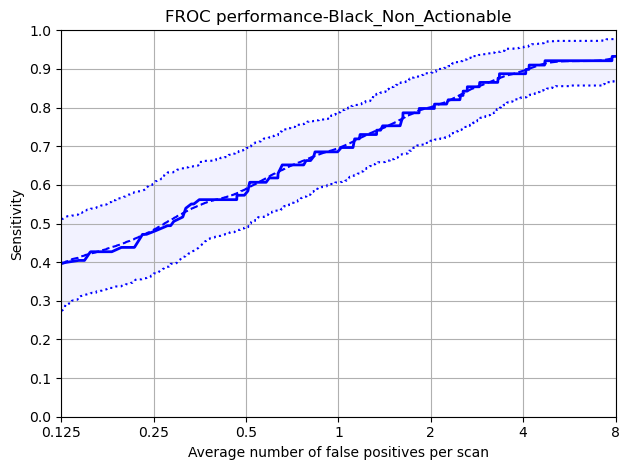

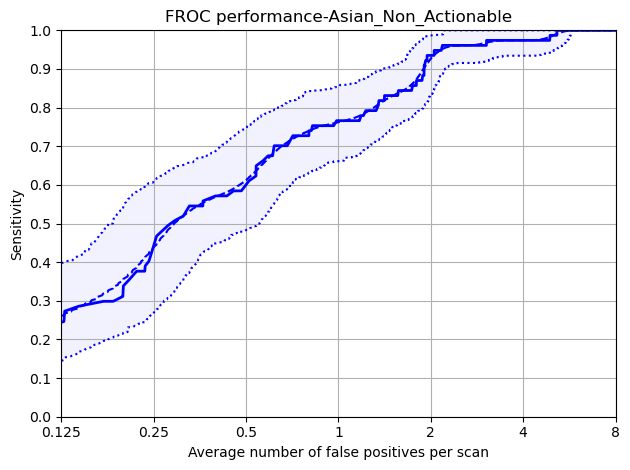

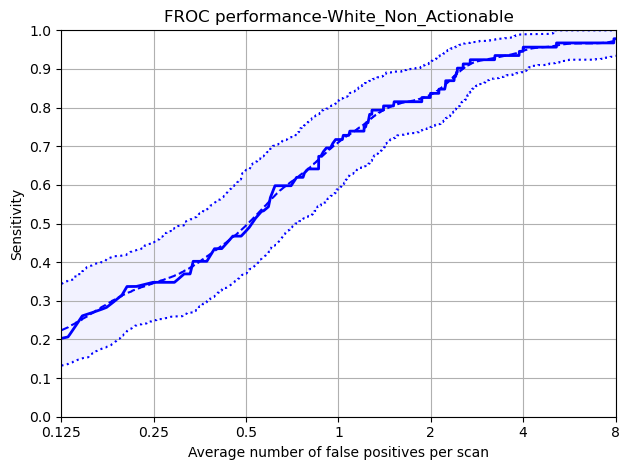

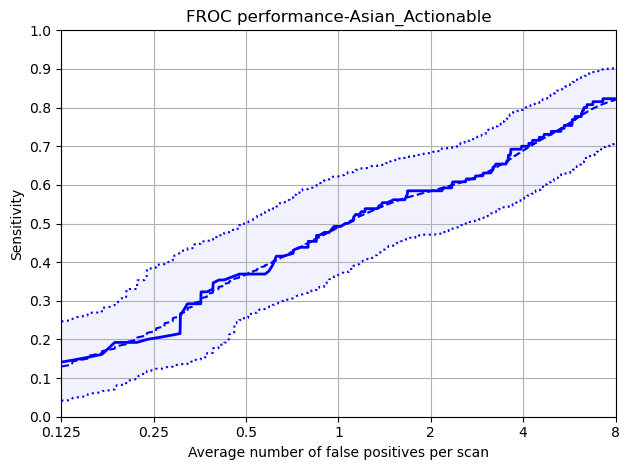

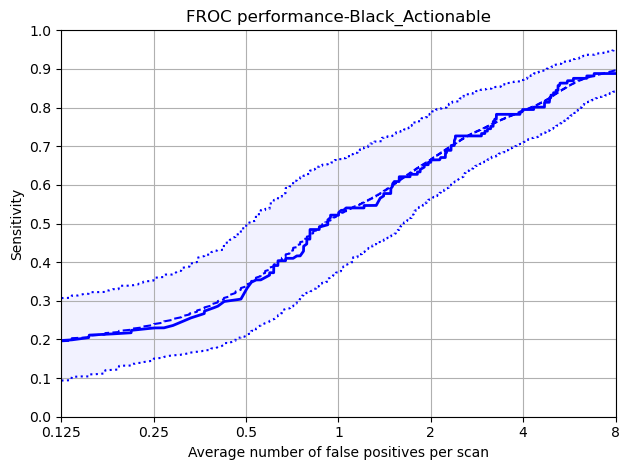

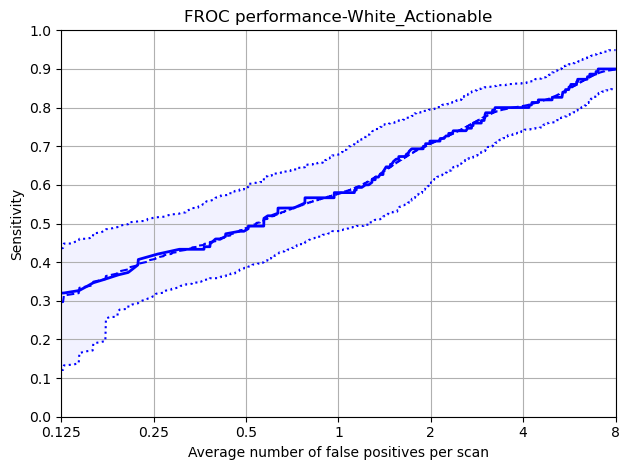

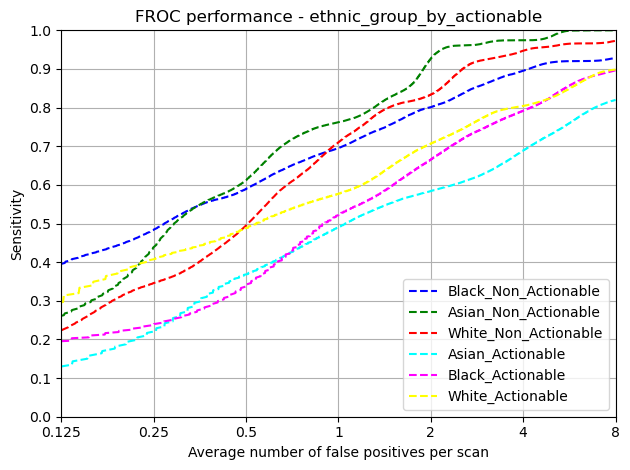

In [ ]:
protected_group = 'ethnic_group_is_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/test_balanced/{protected_group}'
)


In [ ]:
protected_group = 'ethnic_group_is_not_actionable'
data_dict = protected_group_analysis(
    protected_group, 
    scan_metadata, 
    annotations, 
    annotations_excluded, 
    predictions, 
    f'{workspace_path}/results/detection/trained_summit/summit/test_balanced/{protected_group}'
)


### False Positive and Miss Analysis


In [ ]:
thresholds = get_thresholds(detection_summit_summit)
print(thresholds)
missed_metadata = miss_anaysis_at_fpps(
    scans_path=f'{workspace_path}/metadata/summit/test_balanced/test_scans.csv',
    annotations_path=f'{workspace_path}/models/detection/result/trained_summit/summit/test_balanced/annotations.csv',
    exclusions_path=f'{workspace_path}/data/summit/metadata/annotations_excluded_empty.csv',
    predictions_path=detection_predictions_path,
    thresholds=thresholds
)

[0.994140625, 0.9892578125, 0.9814453125, 0.9638671875, 0.9189453125, 0.7685546875, 0.42529296875]
/Users/john/Projects/SOTAEvaluationNoduleDetection/models/detection/result/trained_summit/summit/test_balanced/annotations.csv
Total number of included nodule annotations: 699
Total number of nodule annotations: 699
Cases: 595
Missed Annotations at 0.994140625 FPPs: 562
/Users/john/Projects/SOTAEvaluationNoduleDetection/models/detection/result/trained_summit/summit/test_balanced/annotations.csv
Total number of included nodule annotations: 699
Total number of nodule annotations: 699
Cases: 595
Missed Annotations at 0.9892578125 FPPs: 475
/Users/john/Projects/SOTAEvaluationNoduleDetection/models/detection/result/trained_summit/summit/test_balanced/annotations.csv
Total number of included nodule annotations: 699
Total number of nodule annotations: 699
Cases: 595
Missed Annotations at 0.9814453125 FPPs: 373
/Users/john/Projects/SOTAEvaluationNoduleDetection/models/detection/result/trained_sum

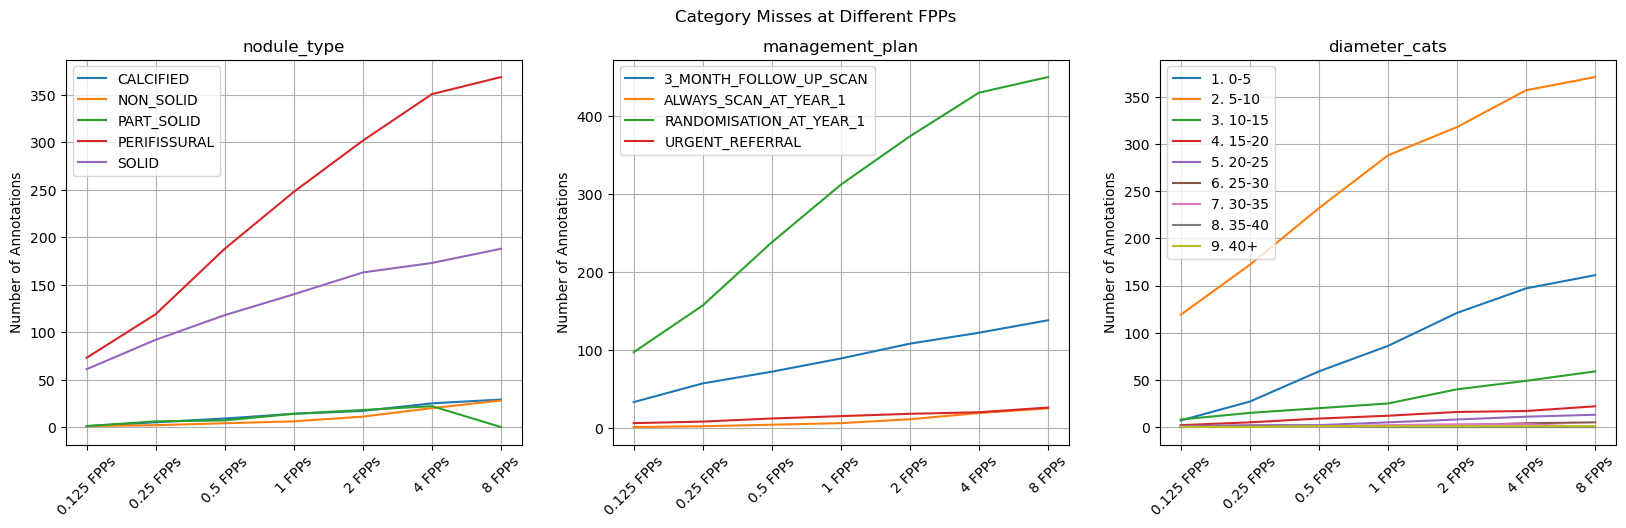

In [ ]:

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for ivx, var in enumerate(['nodule_type','management_plan','diameter_cats']):
    annotations = pd.read_csv(f'{workspace_path}/models/detection/result/trained_summit/summit/test_balanced/annotations.csv')
    total_vc = annotations[var].value_counts().sort_index().rename('Total Annotations')

    operating_points = ['0.125', '0.25', '0.5', '1', '2', '4', '8']

    results = []
    for idx, metadata in enumerate(missed_metadata):
        vc = metadata[var].value_counts().sort_index()

        results.append((total_vc - vc).rename(f'{operating_points[idx]} FPPs'))

    df = pd.concat(results, axis=1).fillna(0).round(2)

    for column in df.T:
        ax[ivx].plot(df.T[column], label=column)
    
    ax[ivx].set_xticklabels(labels=df.columns, rotation=45)
    ax[ivx].set_title(var)
    ax[ivx].legend()
    ax[ivx].set_ylabel('Number of Annotations')
    ax[ivx].grid(visible=True, which='both')

plt.suptitle('Category Misses at Different FPPs')
plt.show()

FEMALE        MALE       Total
(CALCIFIED, 3_MONTH_FOLLOW_UP_SCAN)      12 (15.6%)  12 (10.8%)  24 (12.8%)
(NON_SOLID, ALWAYS_SCAN_AT_YEAR_1)       13 (16.9%)  19 (17.1%)  32 (17.0%)
(NON_SOLID, RANDOMISATION_AT_YEAR_1)       3 (3.9%)    3 (2.7%)    6 (3.2%)
(PART_SOLID, 3_MONTH_FOLLOW_UP_SCAN)       5 (6.5%)    2 (1.8%)    7 (3.7%)
(PERIFISSURAL, RANDOMISATION_AT_YEAR_1)  28 (36.4%)  51 (45.9%)  79 (42.0%)
(SOLID, 3_MONTH_FOLLOW_UP_SCAN)           8 (10.4%)   10 (9.0%)   18 (9.6%)
(SOLID, RANDOMISATION_AT_YEAR_1)           4 (5.2%)    6 (5.4%)   10 (5.3%)
(SOLID, URGENT_REFERRAL)                   4 (5.2%)    8 (7.2%)   12 (6.4%)
Total                                            77         111         188

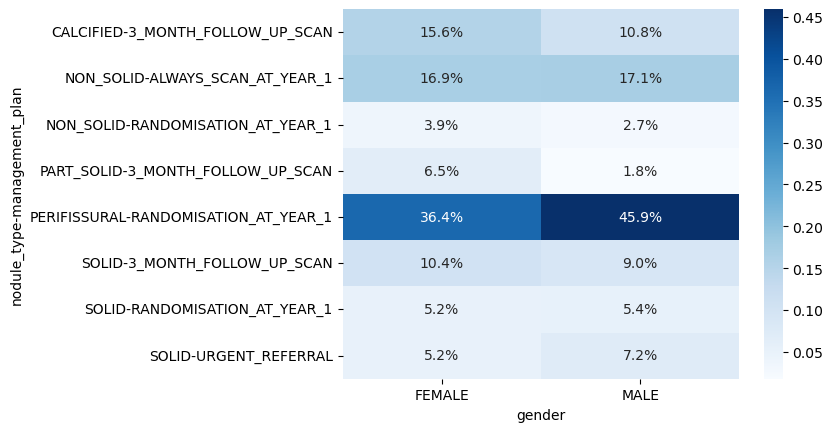

In [ ]:
# Check what nodules have been missed by gender


missed_metadata_at_2fpps = missed_metadata[4]

def crosstab_with_percentages(rows, columns, x_order=None, y_order=None, table=False, heatmap=False):
    # Create the crosstab with absolutes
    cols = [c.astype(str) for c in columns]
    rows = [r.astype(str) for r in rows]

    xabs = pd.crosstab(rows, cols).fillna(0)
    xperc = pd.crosstab(rows, cols, normalize='columns').fillna(0)

    if x_order:
        xabs = xabs.reindex(x_order, axis=1)
        xperc = xperc.reindex(x_order, axis=1)

    if y_order:
        xabs = xabs.reindex(y_order)
        xperc = xperc.reindex(y_order)

    combined_data = {}

    for (adx, rabs), (pdx, rperc) in zip(xabs.iterrows(), xperc.iterrows()):

        row_data = {}
        row_total = 0

        for col in xabs.columns:
            row_data[col] = f"{rabs[col]} ({rperc[col]:.1%})"
            row_total += rabs[col]

        row_data['Total'] = f'{row_total} ({row_total / xabs.sum().sum():.1%})'
        combined_data[adx] = row_data

    row_data = {}
    row_total = 0
    for col in xabs.columns:
        row_data[col] = f'{sum(xabs[col])}'
        row_total += xabs[col].sum()

    row_data['Total'] = row_total
    combined_data['Total'] = row_data

    if table:
        display(pd.DataFrame.from_dict(combined_data).T)
        
    
    if heatmap:
        sns.heatmap(xperc, annot=True, fmt=".1%", cmap='Blues')
        plt.show()

    return xperc, pd.DataFrame.from_dict(combined_data)

_ = crosstab_with_percentages(
    [missed_metadata_at_2fpps['nodule_type'], missed_metadata_at_2fpps['management_plan']],
    [missed_metadata_at_2fpps['gender']],
    table=True,
    heatmap=True)

In [ ]:
scans = pd.read_csv(f'{workspace_path}/metadata/summit/test_balanced/test_scans.csv')
predictions = pd.read_csv(detection_predictions_path)
annotations = pd.read_csv(f'{workspace_path}/models/detection/result/trained_summit/summit/test_balanced/annotations.csv')

false_positives_fpps = false_positive_analysis(
    thresholds=thresholds,    
    predictions=predictions,
    annotations=annotations
)

predictions: 204 at threshold: 0.994140625
distance false positives: 67 at threshold: 0.994140625
predictions: 360 at threshold: 0.9892578125
distance false positives: 136 at threshold: 0.9892578125
predictions: 608 at threshold: 0.9814453125
distance false positives: 282 at threshold: 0.9814453125
predictions: 1010 at threshold: 0.9638671875
distance false positives: 588 at threshold: 0.9638671875
predictions: 1698 at threshold: 0.9189453125
distance false positives: 1185 at threshold: 0.9189453125
predictions: 2982 at threshold: 0.7685546875
distance false positives: 2375 at threshold: 0.7685546875
predictions: 5470 at threshold: 0.42529296875
distance false positives: 4757 at threshold: 0.42529296875


In [ ]:
df = false_positives_fpps['0.125']

cnt = 0
for idx, row in df[df.distance_false_positive].sort_values(by='threshold', ascending=False).iterrows():
    scan_id = row['name']
    study_id = scan_id.split('_')[0]
    x = row['row']
    y = row['col']
    z = row['index']
    diameter = row['diameter']
    

    copy_scan_from_cluster(scan_id)
    
    scan = SummitScan.load_scan(f'{workspace_path}/data/summit/scans/{study_id}/{scan_id}.mhd')
    irc = xyz2irc([x, y, z], scan.origin, scan.voxel_size, scan.orientation)


    show_mhd_candidate_location(scan.image, irc.row, irc.col, irc.index, diameter, row.distance_false_positive, row.iou_false_positive)
    cnt+=1
    if cnt == 12:
        break

summit-9294-yyy_Y0_BASELINE_A already exists


TypeError: show_mhd_candidate_location() missing 1 required positional argument: 'iou_false_positive'